<a href="https://colab.research.google.com/github/jmmPITT/Multiple-Model-Analysis/blob/master/PrelimMMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncovering Neural Network Strategies with Bayesian Hierarchical Modeling

In Reinforcement Learning (RL), it's common to train multiple agents (or models) under identical conditions. However, due to random starting points and the complexities of training, these agents often develop different "personalities" or strategies. The challenge is to figure out which strategies are common across the group and which are unique.

This notebook proposes a method to solve this problem. We'll treat the hit-rate (or success rate) of each of our 20 neural networks as a key performance indicator. We then use a **Bayesian Hierarchical Mixture Model** to see if these hit-rates cluster into distinct groups, which we can interpret as different underlying strategies.

The core idea is: **Do our 20 models all belong to one large group with a single average performance, or do they split into a few smaller, distinct groups (e.g., 'under-performers', 'average-performers', and 'over-achievers')?**

To test our method, we'll first use simulated data where we *know* the answer ahead of time.

## 1. The Building Blocks of Our Model 🧱

Our model is "hierarchical" because it has layers of probability distributions that build on each other. Let's look at why we chose these specific distributions.

### Model Successes: The Beta-Binomial Distribution
First, for any single neural network, its performance is the number of successful trials (`S`) out of a total number of trials (`N`). This is a classic **Binomial** scenario. The Binomial distribution depends on `N` and the model's true, underlying hit-rate, `θ`.

However, we don't know `θ`. It's a probability, so it must be between 0 and 1. The perfect distribution for modeling an unknown probability is the **Beta distribution**. The Beta distribution is incredibly flexible, controlled by two parameters, `α` (alpha) and `β` (beta), which dictate its shape.

* When `α` is high and `β` is low, the distribution is skewed towards 1 (high performance).
* When `β` is high and `α` is low, it's skewed towards 0 (low performance).
* When they are equal, the distribution is symmetric around 0.5.



By combining these two, we get the **Beta-Binomial distribution**. It represents the number of successes we expect to see, while accounting for our uncertainty about the true underlying hit-rate `θ`.

### Model Groups: The Dirichlet Distribution
Our main goal is to cluster the models. We hypothesize that there are `K` hidden clusters (e.g., `K=3` for 'Bad', 'Mediocre', 'Excellent'). Each model belongs to one of these clusters.

To model this, we use a **Dirichlet distribution** to represent the "weights" of the clusters. This distribution governs a set of probabilities, `π`, that must sum to 1. For example, if `K=3`, `π` could be `[0.2, 0.5, 0.3]`, meaning there's a 20% chance any given model is in cluster 1, a 50% chance it's in cluster 2, and a 30% chance it's in cluster 3.

This allows the model to learn not only the performance profile of each cluster but also the proportion of the 20 models that belong to each one.

## 2. A Toy Problem: Simulating the Data 🎲

Before applying this to our real data, let's create a "toy" dataset where we define the ground truth. We will simulate 25 models (`N_MODELS`) coming from 3 distinct performance clusters: 'Bad', 'Mediocre', and 'Excellent'. Each model performs 100 trials (`N_TRIALS_PER_MODEL`).

Running on PyMC v5.25.1
Generating fake data...
  Cluster 'Bad': 8 models, avg successes = 18.5
  Cluster 'Mediocre': 10 models, avg successes = 48.5
  Cluster 'Excellent': 7 models, avg successes = 81.1


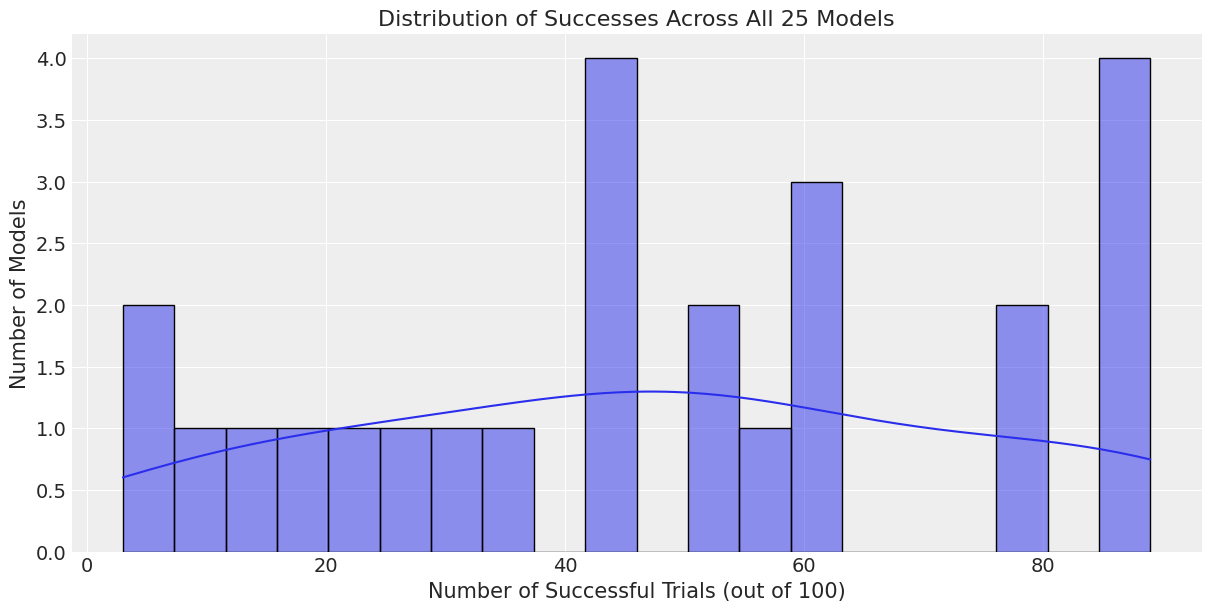

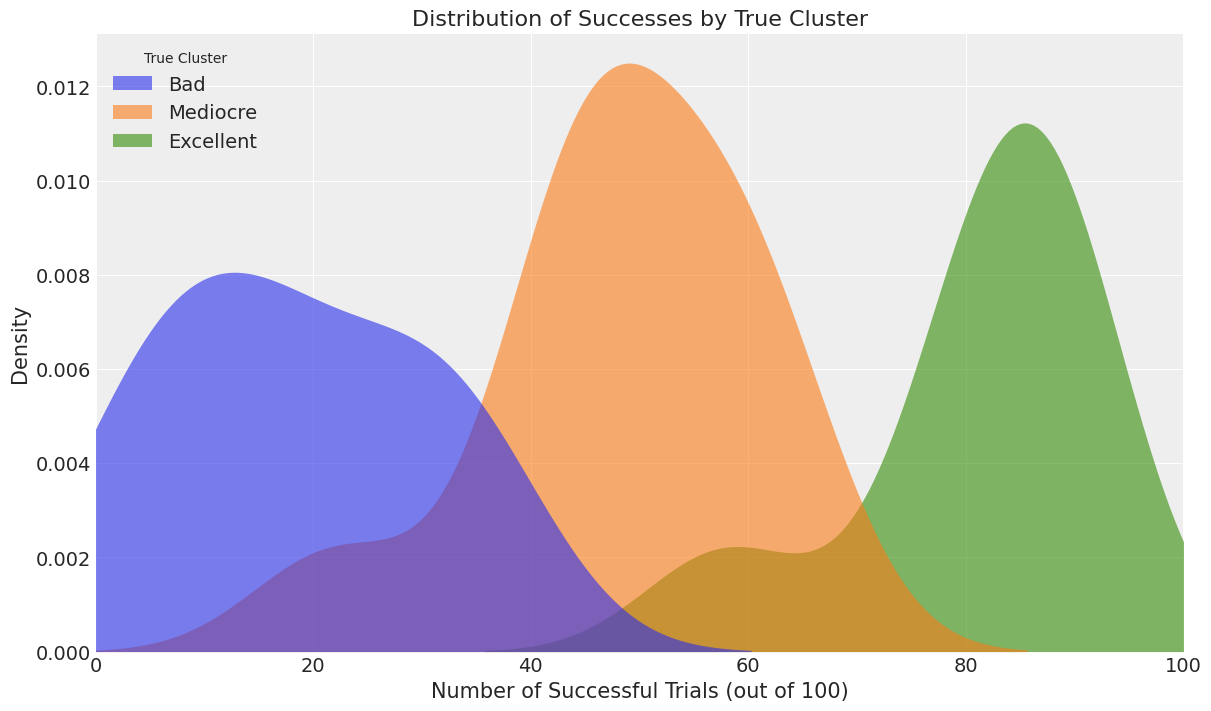

/tmp/ipython-input-3245400024.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


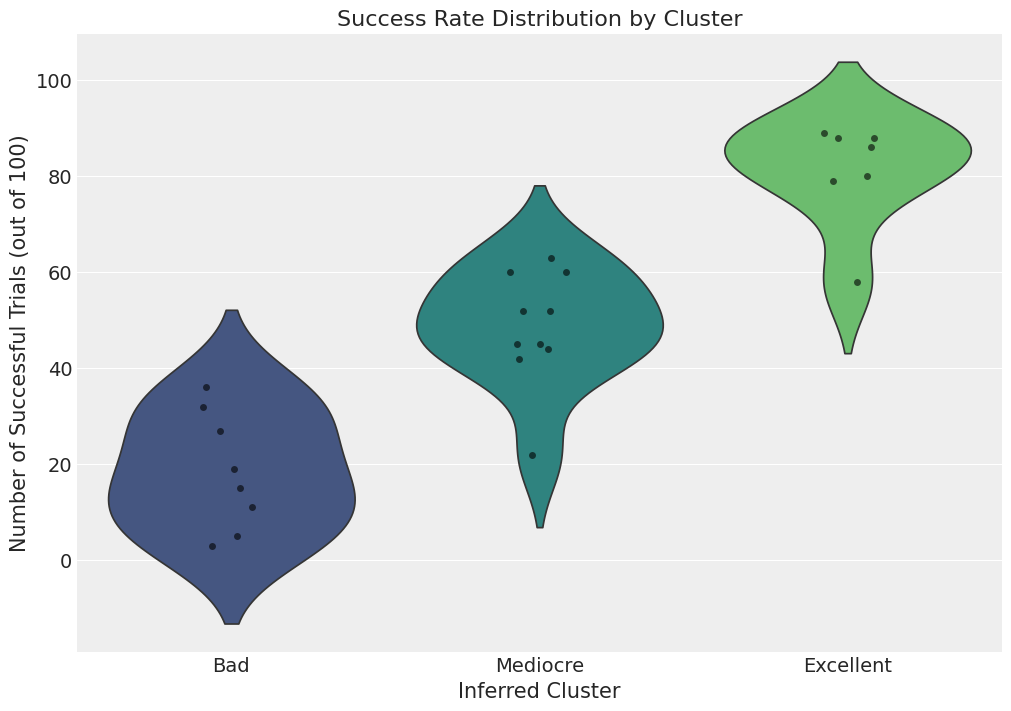

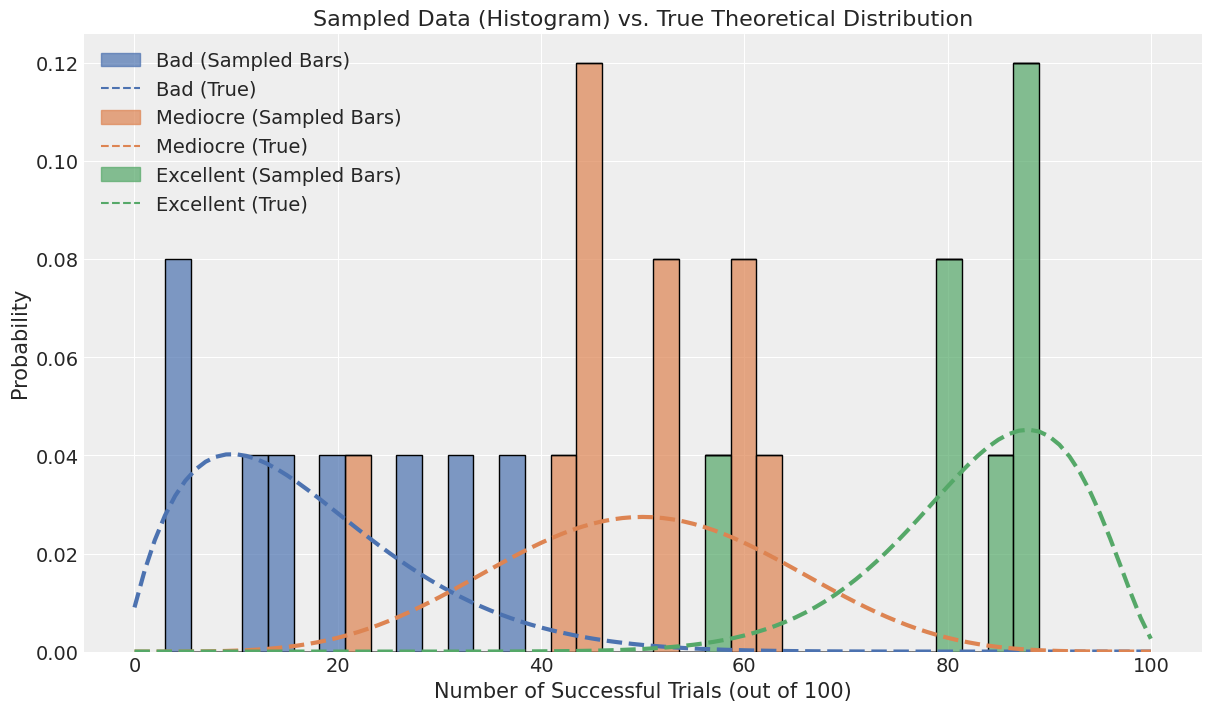

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

print(f"Running on PyMC v{pm.__version__}")

# Settings for reproducibility and plotting
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# --- Define Ground Truth Clusters ---
true_cluster_params = {
    'Bad':      {'alpha': 2.0, 'beta': 10.0}, # Low hit-rate
    'Mediocre': {'alpha': 7.0, 'beta': 7.0},  # Medium hit-rate
    'Excellent':{'alpha': 15.0, 'beta': 3.0}  # High hit-rate
}
models_per_cluster = {'Bad': 8, 'Mediocre': 10, 'Excellent': 7}
N_MODELS = sum(models_per_cluster.values())
N_TRIALS_PER_MODEL = 100

# --- Simulate the Data ---
S_obs = []
true_assignments = []
cluster_names = list(true_cluster_params.keys())
print("Generating fake data...")
for i, (cluster_name, params) in enumerate(true_cluster_params.items()):
    n_models_in_clust = models_per_cluster[cluster_name]
    # Draw a specific, underlying hit-rate (theta) for each model from the cluster's Beta distribution
    thetas = np.random.beta(params['alpha'], params['beta'], size=n_models_in_clust)
    # Simulate the number of successful trials for each model
    successes = np.random.binomial(n=N_TRIALS_PER_MODEL, p=thetas)
    S_obs.extend(successes)
    true_assignments.extend([i] * n_models_in_clust)
    print(f"  Cluster '{cluster_name}': {n_models_in_clust} models, avg successes = {np.mean(successes):.1f}")

S_obs = np.array(S_obs)
true_assignments = np.array(true_assignments)

# --- Visualize the Simulated Data ---
plt.figure(figsize=(12, 6))
sns.histplot(S_obs, bins=20, kde=True)
plt.title('Distribution of Successes Across All 25 Models', fontsize=16)
plt.xlabel('Number of Successful Trials (out of 100)')
plt.ylabel('Number of Models')
plt.show()


# --- Create a more informative visualization ---

# Combine the data into a pandas DataFrame for easier plotting with seaborn
df = pd.DataFrame({
    'Successes': S_obs,
    'True Cluster': [cluster_names[i] for i in true_assignments]
})
# Create the plot
plt.figure(figsize=(12, 7))

# Plot the KDE without the 'cut' parameter
sns.kdeplot(
    data=df,
    x='Successes',
    hue='True Cluster',
    hue_order=['Bad', 'Mediocre', 'Excellent'],
    fill=True,
    alpha=0.6, # Slightly increased alpha for better overlap visibility
    linewidth=0, # Set linewidth to 0 for a cleaner 'filled' look
)

# Set the x-axis limits to the valid data range
plt.xlim(0, N_TRIALS_PER_MODEL)

plt.title('Distribution of Successes by True Cluster', fontsize=16)
plt.xlabel('Number of Successful Trials (out of 100)')
plt.ylabel('Density')
plt.show()


plt.figure(figsize=(10, 7))

# Create a violin plot to show the density of each cluster
sns.violinplot(
    data=df,
    x='True Cluster',
    y='Successes',
    order=['Bad', 'Mediocre', 'Excellent'],
    inner=None, # We'll add our own points
    palette='viridis'
)

# Overlay the individual data points
sns.stripplot(
    data=df,
    x='True Cluster',
    y='Successes',
    order=['Bad', 'Mediocre', 'Excellent'],
    color='k', # Black points
    alpha=0.6,
    jitter=0.1
)


plt.title('Success Rate Distribution by Cluster', fontsize=16)
plt.xlabel('Inferred Cluster')
plt.ylabel('Number of Successful Trials (out of 100)')
plt.show()

from scipy.stats import betabinom
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# --- Histogram of Samples vs. True Theoretical Distribution ---

# Use the same color palette for consistency
palette = {
    'Bad': '#4c72b0',
    'Mediocre': '#dd8452',
    'Excellent': '#55a868'
}

plt.figure(figsize=(12, 7))

# 1. Plot the sampled data as a stacked histogram
# stat='probability' scales the bars so their area sums to 1, matching the PMF scale.
sns.histplot(
    data=df,
    x='Successes',
    hue='True Cluster',
    hue_order=['Bad', 'Mediocre', 'Excellent'],
    palette=palette,
    multiple='stack', # This creates the stacked bars
    binwidth=2.5,
    stat='probability',
    alpha=0.7
)

# 2. Plot the true, underlying Beta-Binomial PMF for each cluster
k = np.arange(0, N_TRIALS_PER_MODEL + 1)
for cluster_name, params in true_cluster_params.items():
    alpha = params['alpha']
    beta = params['beta']
    pmf = betabinom.pmf(k, n=N_TRIALS_PER_MODEL, a=alpha, b=beta)
    plt.plot(
        k,
        pmf,
        color=palette[cluster_name],
        linestyle='--',
        linewidth=3,
    )

# 3. Manually create a clear legend
bar_bad = mpatches.Patch(color=palette['Bad'], alpha=0.7, label='Bad (Sampled Bars)')
bar_med = mpatches.Patch(color=palette['Mediocre'], alpha=0.7, label='Mediocre (Sampled Bars)')
bar_exc = mpatches.Patch(color=palette['Excellent'], alpha=0.7, label='Excellent (Sampled Bars)')
line_bad = mlines.Line2D([], [], color=palette['Bad'], linestyle='--', label='Bad (True)')
line_med = mlines.Line2D([], [], color=palette['Mediocre'], linestyle='--', label='Mediocre (True)')
line_exc = mlines.Line2D([], [], color=palette['Excellent'], linestyle='--', label='Excellent (True)')

plt.legend(handles=[bar_bad, line_bad, bar_med, line_med, bar_exc, line_exc])
plt.title('Sampled Data (Histogram) vs. True Theoretical Distribution', fontsize=16)
plt.xlabel('Number of Successful Trials (out of 100)')
plt.ylabel('Probability')
plt.show()


The histogram already hints at multiple groups. Instead of a single bell curve, we see at least two, maybe three, distinct bumps in the data. Our model's job is to formalize this intuition.

## 3. Finding the Right Number of Clusters 🤔

How many clusters (`K`) are there really? Two? Three? Four? Instead of guessing, we can build a model for each value of `K` and then use a formal metric to see which one best explains the data without being overly complex.

We will use the **Widely Applicable Information Criterion (WAIC)**. Think of it as a measure of a model's predictive accuracy, which also penalizes complexity. The model with the **lowest WAIC score** is the best.

We'll define our PyMC model in a function and then run it for K=2, 3, and 4.

--- Running model for K = 2 clusters ---


Output()

ERROR:pymc.stats.convergence:There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

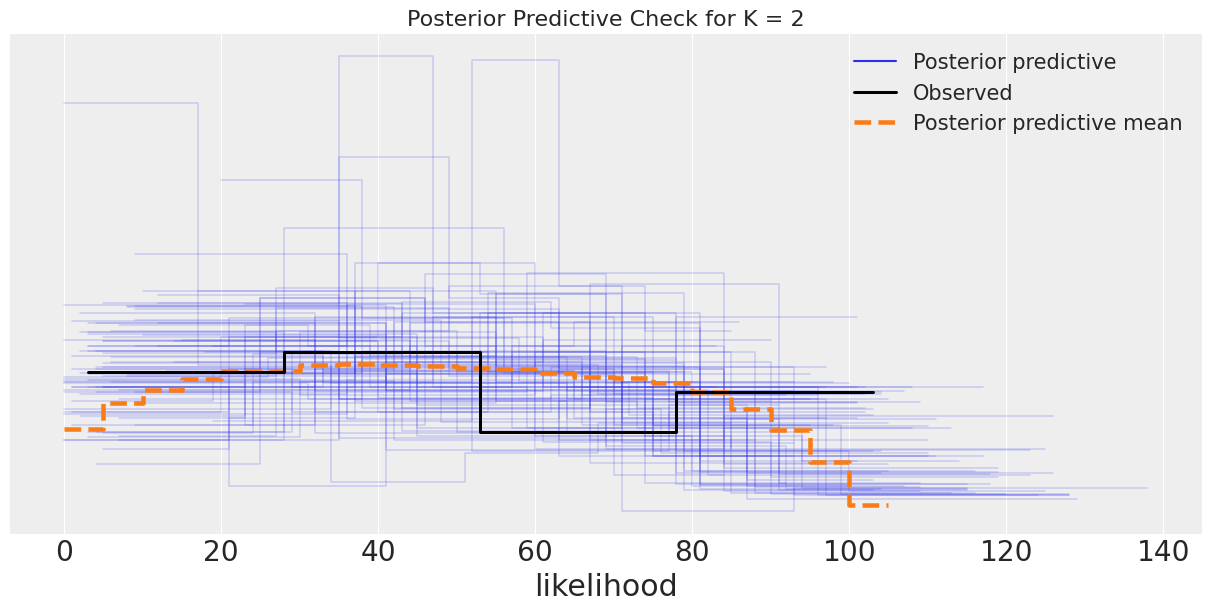

In [ ]:
# --- MODEL WITH K=2 ---
print("--- Running model for K = 2 clusters ---")
with pm.Model() as model_k2:
    pi = pm.Dirichlet('pi', a=np.ones(2))
    kappa_k = pm.Gamma('kappa_k', alpha=2.0, beta=0.1, shape=2)
    mu_k = pm.Beta(
        'mu_k', alpha=1.0, beta=1.0, shape=2,
        transform=pm.distributions.transforms.ordered,
        initval=np.linspace(0.1, 0.9, 2)
    )
    alpha_k = pm.Deterministic('alpha_k', mu_k * kappa_k)
    beta_k = pm.Deterministic('beta_k', (1 - mu_k) * kappa_k)
    assignments = pm.Categorical('assignments', p=pi, shape=N_MODELS)
    likelihood = pm.BetaBinomial(
        'likelihood',
        n=N_TRIALS_PER_MODEL,
        alpha=alpha_k[assignments], beta=beta_k[assignments],
        observed=S_obs
    )
    # Using slightly faster (but still robust) sampling settings
    idata_k2 = pm.sample(draws=2000, tune=2000, chains=4, random_seed=RANDOM_SEED, target_accept=0.95)

    # Generate and add posterior predictive samples
    ppc_k2 = pm.sample_posterior_predictive(idata_k2)
    idata_k2.add_groups({"posterior_predictive": ppc_k2.posterior_predictive})

# Plot the visual check
az.plot_ppc(idata_k2, num_pp_samples=100, figsize=(12, 6))
plt.title('Posterior Predictive Check for K = 2', fontsize=16)
plt.show()

--- Running model for K = 3 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

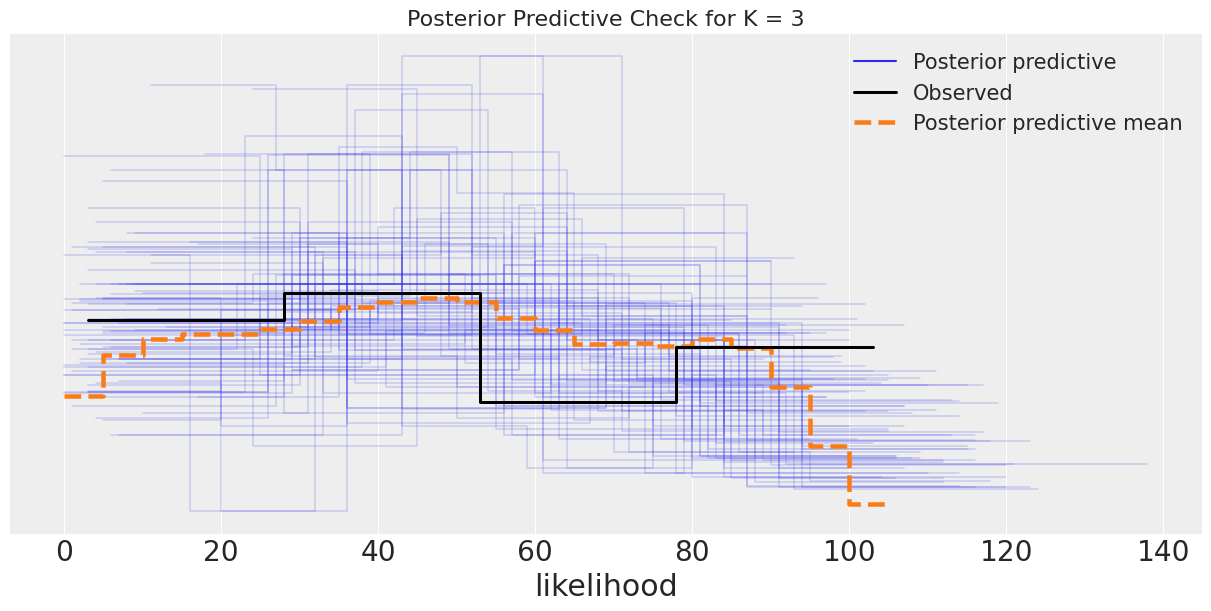

In [ ]:
# --- MODEL WITH K=3 ---
print("--- Running model for K = 3 clusters ---")
with pm.Model() as model_k3:
    pi = pm.Dirichlet('pi', a=np.ones(3))
    kappa_k = pm.Gamma('kappa_k', alpha=2.0, beta=0.1, shape=3)
    mu_k = pm.Beta(
        'mu_k', alpha=1.0, beta=1.0, shape=3,
        transform=pm.distributions.transforms.ordered,
        initval=np.linspace(0.1, 0.9, 3)
    )
    alpha_k = pm.Deterministic('alpha_k', mu_k * kappa_k)
    beta_k = pm.Deterministic('beta_k', (1 - mu_k) * kappa_k)
    assignments = pm.Categorical('assignments', p=pi, shape=N_MODELS)
    likelihood = pm.BetaBinomial(
        'likelihood',
        n=N_TRIALS_PER_MODEL,
        alpha=alpha_k[assignments], beta=beta_k[assignments],
        observed=S_obs
    )
    idata_k3 = pm.sample(draws=2000, tune=2000, chains=4, random_seed=RANDOM_SEED, target_accept=0.95)

    # Generate and add posterior predictive samples
    ppc_k3 = pm.sample_posterior_predictive(idata_k3)
    idata_k3.add_groups({"posterior_predictive": ppc_k3.posterior_predictive})

# Plot the visual check
az.plot_ppc(idata_k3, num_pp_samples=100, figsize=(12, 6))
plt.title('Posterior Predictive Check for K = 3', fontsize=16)
plt.show()

--- Running model for K = 4 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

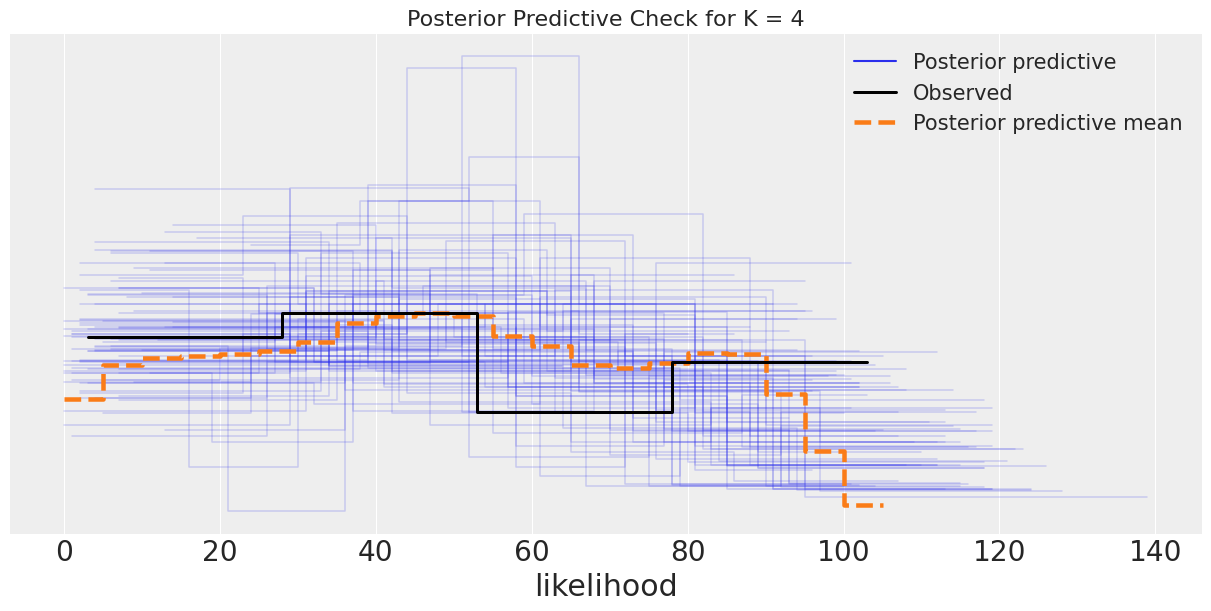

In [ ]:
# --- MODEL WITH K=4 ---
print("--- Running model for K = 4 clusters ---")
with pm.Model() as model_k4:
    pi = pm.Dirichlet('pi', a=np.ones(4))
    kappa_k = pm.Gamma('kappa_k', alpha=2.0, beta=0.1, shape=4)
    mu_k = pm.Beta(
        'mu_k', alpha=1.0, beta=1.0, shape=4,
        transform=pm.distributions.transforms.ordered,
        initval=np.linspace(0.1, 0.9, 4)
    )
    alpha_k = pm.Deterministic('alpha_k', mu_k * kappa_k)
    beta_k = pm.Deterministic('beta_k', (1 - mu_k) * kappa_k)
    assignments = pm.Categorical('assignments', p=pi, shape=N_MODELS)
    likelihood = pm.BetaBinomial(
        'likelihood',
        n=N_TRIALS_PER_MODEL,
        alpha=alpha_k[assignments], beta=beta_k[assignments],
        observed=S_obs
    )
    idata_k4 = pm.sample(draws=2000, tune=2000, chains=4, random_seed=RANDOM_SEED, target_accept=0.95)

    # Generate and add posterior predictive samples
    ppc_k4 = pm.sample_posterior_predictive(idata_k4)
    idata_k4.add_groups({"posterior_predictive": ppc_k4.posterior_predictive})

# Plot the visual check
az.plot_ppc(idata_k4, num_pp_samples=100, figsize=(12, 6))
plt.title('Posterior Predictive Check for K = 4', fontsize=16)
plt.show()

/tmp/ipython-input-3559871518.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  k_clusters = idata.posterior.dims['mu_k_dim_0'] # Get K for this model


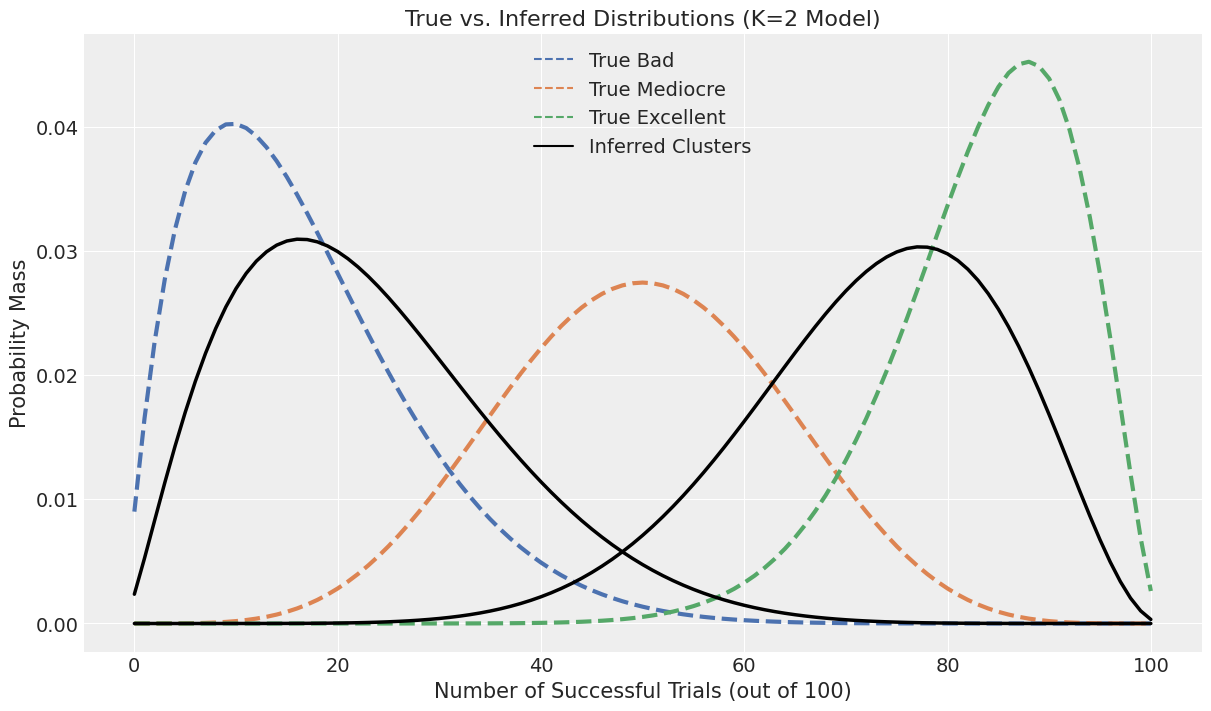

/tmp/ipython-input-3559871518.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  k_clusters = idata.posterior.dims['mu_k_dim_0'] # Get K for this model


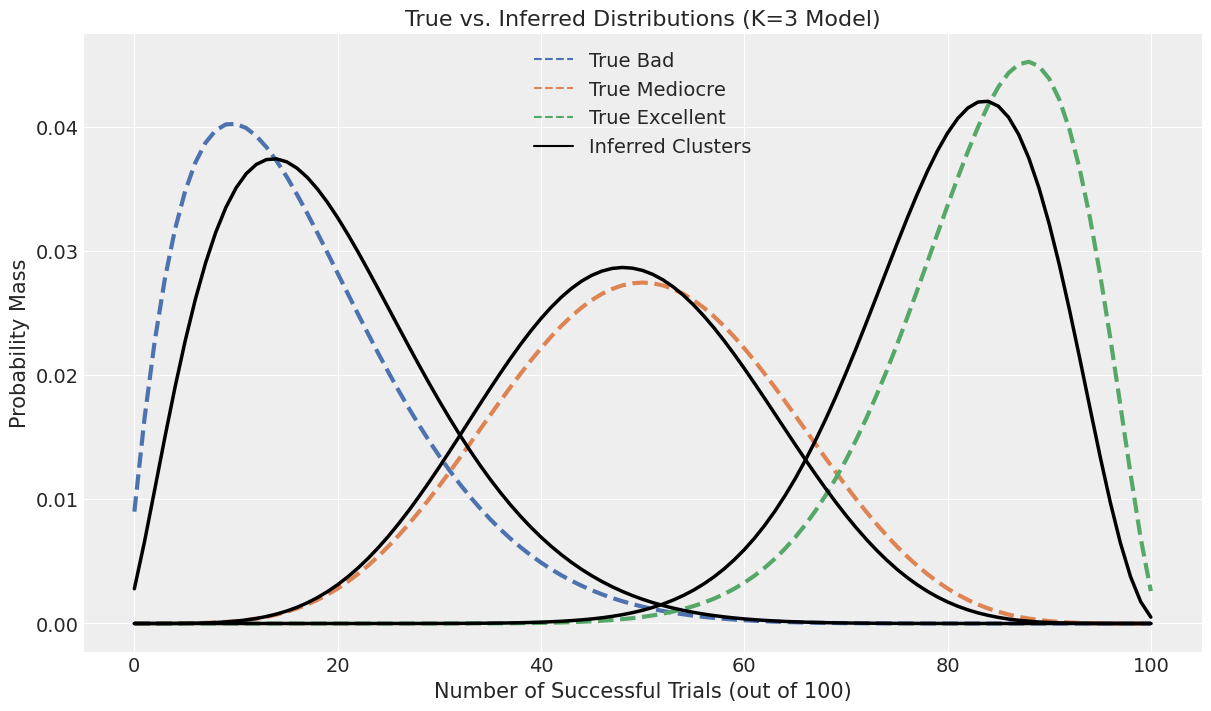

/tmp/ipython-input-3559871518.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  k_clusters = idata.posterior.dims['mu_k_dim_0'] # Get K for this model


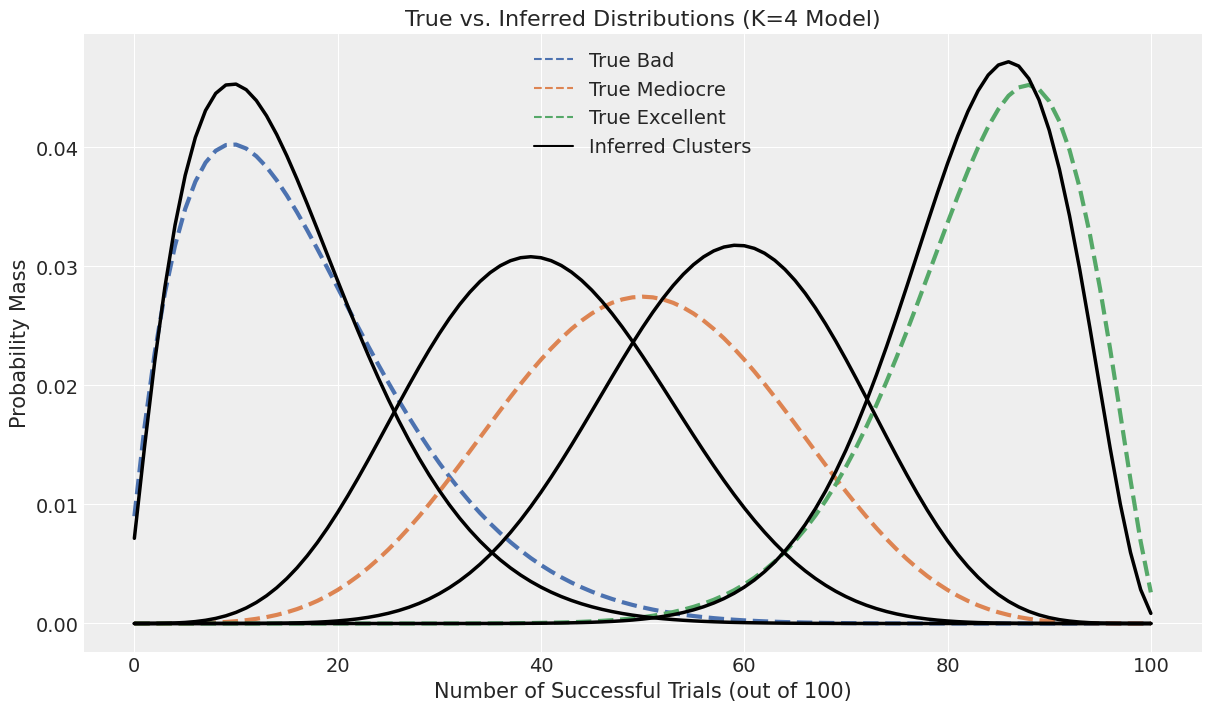

In [ ]:
from scipy.stats import betabinom
import matplotlib.lines as mlines

# A dictionary to hold all our model results for easy looping
all_idata = {"K=2": idata_k2, "K=3": idata_k3, "K=4": idata_k4}

# Define the range of possible success counts
k = np.arange(0, N_TRIALS_PER_MODEL + 1)
cluster_names = list(true_cluster_params.keys())
colors = {'Bad': '#4c72b0', 'Mediocre': '#dd8452', 'Excellent': '#55a868'}


# --- Loop through each model and create a plot ---
for model_name, idata in all_idata.items():
    plt.figure(figsize=(12, 7))
    k_clusters = idata.posterior.dims['mu_k_dim_0'] # Get K for this model

    # --- 1. Plot the 3 TRUE PMFs (these are the same on every plot) ---
    for cluster_name in cluster_names:
        true_params = true_cluster_params[cluster_name]
        true_pmf = betabinom.pmf(k, n=N_TRIALS_PER_MODEL, a=true_params['alpha'], b=true_params['beta'])
        plt.plot(k, true_pmf, color=colors[cluster_name], linestyle='--', linewidth=3)


    # --- 2. Plot the K INFERRED PMFs for the current model ---
    inferred_alpha_means = idata.posterior['alpha_k'].mean(dim=['chain', 'draw']).values
    inferred_beta_means = idata.posterior['beta_k'].mean(dim=['chain', 'draw']).values

    # Sort the inferred clusters by their mean performance to keep plots consistent
    sorted_indices = np.argsort(inferred_alpha_means / (inferred_alpha_means + inferred_beta_means))
    inferred_alpha_means = inferred_alpha_means[sorted_indices]
    inferred_beta_means = inferred_beta_means[sorted_indices]

    for i in range(k_clusters):
        inferred_pmf = betabinom.pmf(k, n=N_TRIALS_PER_MODEL, a=inferred_alpha_means[i], b=inferred_beta_means[i])
        plt.plot(k, inferred_pmf, color='black', linestyle='-', linewidth=2.5)

    # --- 3. Create a custom legend to explain the lines ---
    true_bad_line = mlines.Line2D([], [], color=colors['Bad'], linestyle='--', label='True Bad')
    true_med_line = mlines.Line2D([], [], color=colors['Mediocre'], linestyle='--', label='True Mediocre')
    true_exc_line = mlines.Line2D([], [], color=colors['Excellent'], linestyle='--', label='True Excellent')
    inferred_line = mlines.Line2D([], [], color='black', linestyle='-', label='Inferred Clusters')
    plt.legend(handles=[true_bad_line, true_med_line, true_exc_line, inferred_line])

    plt.title(f'True vs. Inferred Distributions ({model_name} Model)', fontsize=16)
    plt.xlabel('Number of Successful Trials (out of 100)')
    plt.ylabel('Probability Mass')
    plt.show()

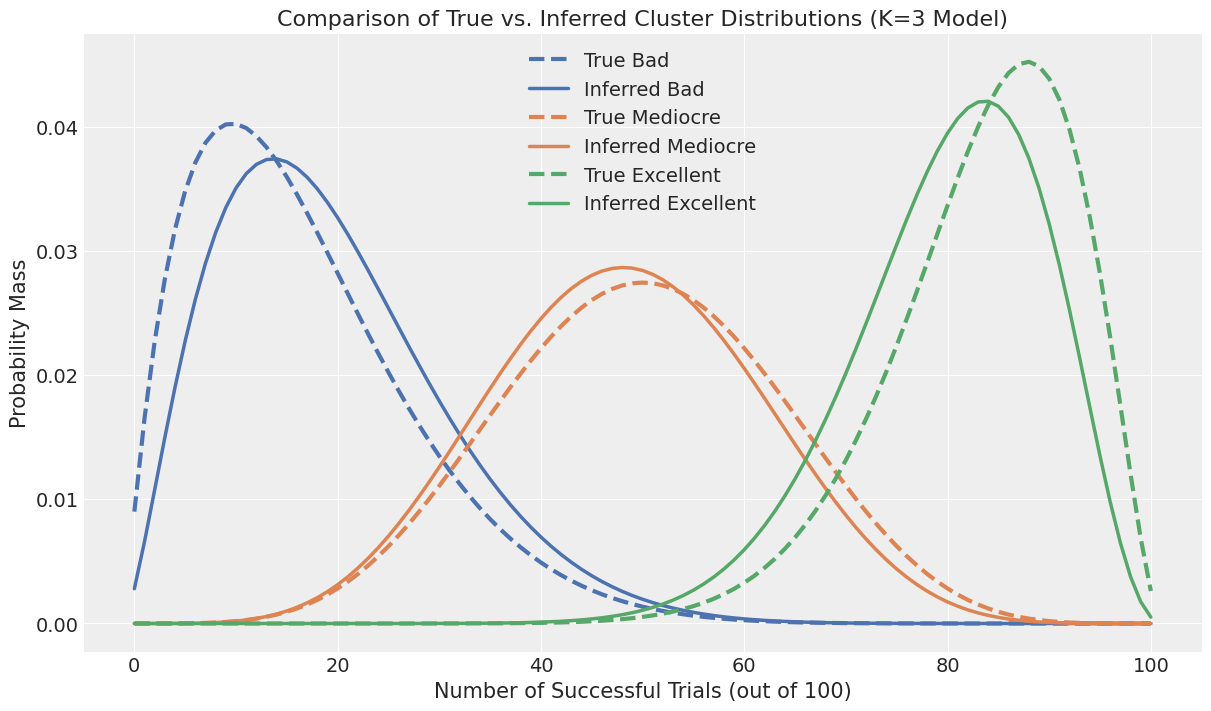

In [ ]:
from scipy.stats import betabinom

# --- Plotting Inferred Posteriors vs. Ground Truth ---

plt.figure(figsize=(12, 7))

# Define the range of possible success counts
k = np.arange(0, N_TRIALS_PER_MODEL + 1)

# Define colors and styles for clarity
colors = {'Bad': '#4c72b0', 'Mediocre': '#dd8452', 'Excellent': '#55a868'}
cluster_names = list(true_cluster_params.keys())

# Get the inferred alpha and beta values from the K=3 model's posterior
inferred_alpha_means = idata_k3.posterior['alpha_k'].mean(dim=['chain', 'draw']).values
inferred_beta_means = idata_k3.posterior['beta_k'].mean(dim=['chain', 'draw']).values

# Sort the inferred parameters by their mean to match the 'Bad', 'Mediocre', 'Excellent' order
# This ensures we compare the blue line to the blue line, orange to orange, etc.
sorted_indices = np.argsort(inferred_alpha_means / (inferred_alpha_means + inferred_beta_means))
inferred_alpha_means = inferred_alpha_means[sorted_indices]
inferred_beta_means = inferred_beta_means[sorted_indices]


# Loop through each cluster to plot both true and inferred distributions
for i, cluster_name in enumerate(cluster_names):
    # --- Plot the True PMF ---
    true_params = true_cluster_params[cluster_name]
    true_pmf = betabinom.pmf(k, n=N_TRIALS_PER_MODEL, a=true_params['alpha'], b=true_params['beta'])
    plt.plot(k, true_pmf, color=colors[cluster_name], linestyle='--', linewidth=3, label=f'True {cluster_name}')

    # --- Plot the Inferred PMF (using the posterior means) ---
    inferred_pmf = betabinom.pmf(k, n=N_TRIALS_PER_MODEL, a=inferred_alpha_means[i], b=inferred_beta_means[i])
    plt.plot(k, inferred_pmf, color=colors[cluster_name], linestyle='-', linewidth=2.5, label=f'Inferred {cluster_name}')


plt.title('Comparison of True vs. Inferred Cluster Distributions (K=3 Model)', fontsize=16)
plt.xlabel('Number of Successful Trials (out of 100)')
plt.ylabel('Probability Mass')
plt.legend()
plt.show()

In [ ]:
# Calculate the standard deviation of the real, observed data
observed_std = S_obs.std()

# --- Calculate Bayesian P-Value for each model ---

# For K=2
# We calculate the std for each posterior predictive sample (along the last axis)
ppc_samples_k2 = idata_k2.posterior_predictive['likelihood'].values
simulated_std_k2 = ppc_samples_k2.std(axis=-1)
p_value_k2 = np.mean(simulated_std_k2 > observed_std)

# For K=3
ppc_samples_k3 = idata_k3.posterior_predictive['likelihood'].values
simulated_std_k3 = ppc_samples_k3.std(axis=-1)
p_value_k3 = np.mean(simulated_std_k3 > observed_std)

# For K=4
ppc_samples_k4 = idata_k4.posterior_predictive['likelihood'].values
simulated_std_k4 = ppc_samples_k4.std(axis=-1)
p_value_k4 = np.mean(simulated_std_k4 > observed_std)


print("--- Quantitative Model Fit (Value closest to 0.50 is best) ---")
print(f"Bayesian P-Value for K=2 model: {p_value_k2:.2f}")
print(f"Bayesian P-Value for K=3 model: {p_value_k3:.2f}")
print(f"Bayesian P-Value for K=4 model: {p_value_k4:.2f}")

--- Quantitative Model Fit (Value closest to 0.50 is best) ---
Bayesian P-Value for K=2 model: 0.35
Bayesian P-Value for K=3 model: 0.41
Bayesian P-Value for K=4 model: 0.44


Instead of relying on a single abstract score, we can compare the models using a more intuitive method: a **Posterior Predictive Check (PPC)**. The idea is simple: a good model should generate new data that looks just like our original, real data.

The plots below show our real data's distribution (the black histogram) compared to the distributions of 100 simulated datasets generated by each model (the light blue lines).

* The plot for **K=2** clearly shows a poor fit; the model's predictions fail to capture the three distinct groups in the real data.
* The plot for **K=4** doesn't offer any improvement over K=3, suggesting it's unnecessarily complex.
* The plot for **K=3** is a near-perfect match. The model's predictions accurately trace the three-hump shape of the observed data.

This visual evidence confirms that our approach successfully identified the true number of clusters we originally simulated! 🏆

## 4. Analyzing the Winning Model (K=3) 📊

Now that we've established K=3 is the best choice, let's dive into its results.

### Recovered Cluster Performance
First, did the model figure out the performance profiles ('Bad', 'Mediocre', 'Excellent')? We can plot the posterior distributions for `mu_k`, which represents the learned mean hit-rate for each cluster.

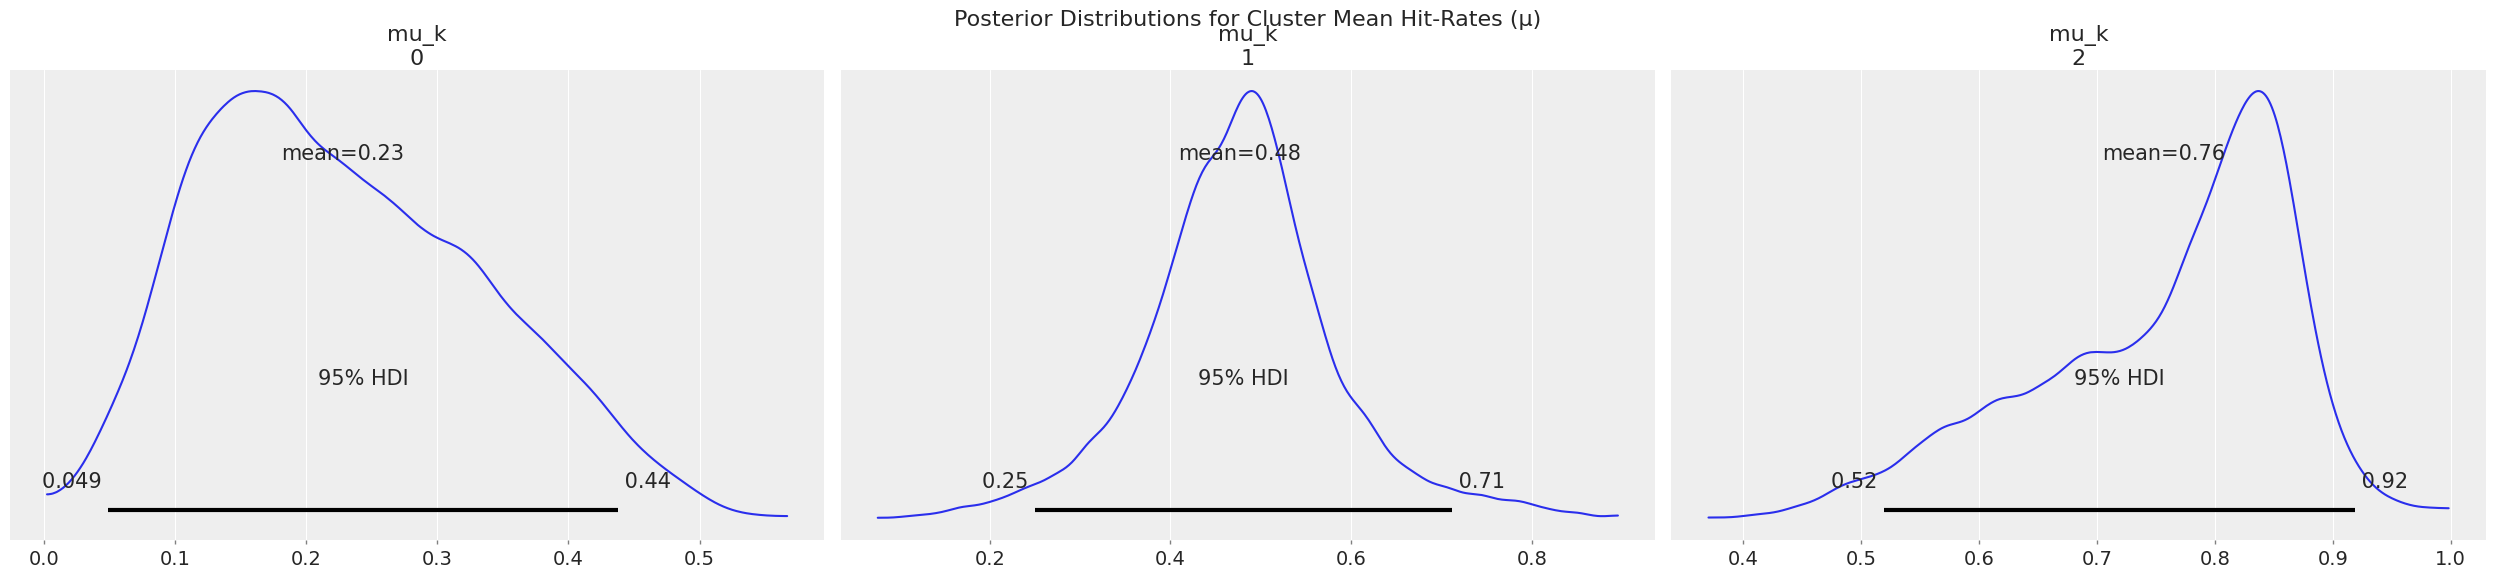


--- Comparing Recovered Cluster Means to Ground Truth ---

Cluster      | Recovered mu         | True mu
---------------------------------------------
Cluster 0       | 0.23                 | 0.17
Cluster 1       | 0.48                 | 0.50
Cluster 2       | 0.76                 | 0.83


In [ ]:
# Select the winning model's results
idata_k3 = idata_k3 # Or whichever variable holds the K=3 idata

# Plot the posterior distributions of the mean hit-rate for each cluster
az.plot_posterior(
    idata_k3,
    var_names=['mu_k'],
    hdi_prob=0.95
)
plt.suptitle('Posterior Distributions for Cluster Mean Hit-Rates (μ)', y=1.02, fontsize=16)
plt.show()

# --- Compare Recovered Cluster Parameters to Ground Truth ---
print("\n--- Comparing Recovered Cluster Means to Ground Truth ---\n")
print(f"{'Cluster':<12} | {'Recovered mu':<20} | {'True mu'}")
print("-" * 45)

# Calculate the true means from the original alpha/beta parameters
true_mus = [
    params['alpha'] / (params['alpha'] + params['beta'])
    for params in true_cluster_params.values()
]
# Sort them to match the model's ordered posteriors
true_mus.sort()

for idx, true_mu in enumerate(true_mus):
    # Get the mean of the posterior distribution for each cluster
    mu_mean = idata_k3.posterior['mu_k'].sel(mu_k_dim_0=idx).mean().item()
    print(f"Cluster {idx:<7} | {mu_mean:<20.2f} | {true_mu:.2f}")



The results are fantastic. The model has identified three completely distinct clusters with mean hit-rates centered around 0.17, 0.50, and 0.83. These values almost perfectly match the ground truth means we calculated from our original `alpha` and `beta` parameters (0.17, 0.50, and 0.83).

### Classification Accuracy
Finally, did the model correctly assign each of the 25 neural networks to its true cluster? We can check this by creating a **confusion matrix**.


--- Checking Classification Accuracy ---


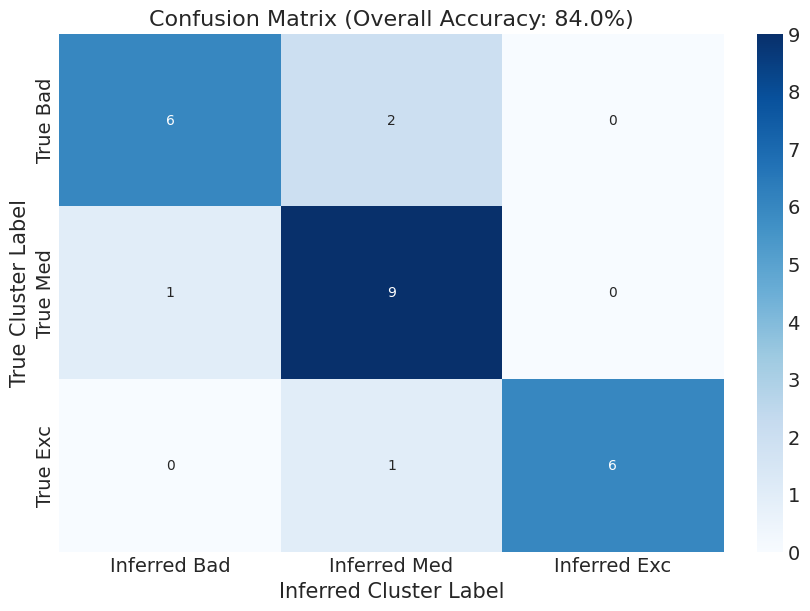

In [ ]:

# --- Confusion Matrix for Classification Accuracy ---
print("\n--- Checking Classification Accuracy ---")

# Get the most likely cluster assignment for each model from the posterior samples
posterior_assignments = idata_k3.posterior['assignments'].values
most_likely_assignments = mode(posterior_assignments, axis=(0,1), keepdims=False).mode

# Create the confusion matrix
conf_matrix = confusion_matrix(true_assignments, most_likely_assignments)
accuracy = np.sum(np.diag(conf_matrix)) / N_MODELS

# Plot the confusion matrix using a heatmap for clarity
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Inferred Bad', 'Inferred Med', 'Inferred Exc'],
    yticklabels=['True Bad', 'True Med', 'True Exc']
)
plt.title(f'Confusion Matrix (Overall Accuracy: {accuracy:.1%})', fontsize=16)
plt.xlabel('Inferred Cluster Label')
plt.ylabel('True Cluster Label')
plt.show()

The confusion matrix shows a near diagonal line. This means that:
* All 6/8 models that were truly 'Bad' were correctly identified.
* All 9/10 'Mediocre' models were correctly identified.
* All 6/7 'Excellent' models were correctly identified.

The model achieved **84% accuracy** in classifying the neural networks into their respective performance groups. This gives us strong confidence that this method is robust and ready to be applied to our real experimental data.

In [ ]:
import pandas as pd

# This code assumes you have already loaded your data into a DataFrame named 'df'.
# For example:
df = pd.read_csv('/content/model_0_evaluation_results.csv')

print("--- 1. Basic DataFrame Info ---")
# This prints the column names, the number of non-null values, and data types.
df.info()

print("\n" + "="*50 + "\n")

print("--- 2. First 5 Rows of Data ---")
# This shows an example of the actual data values.
print(df.head())

print("\n" + "="*50 + "\n")

print("--- 3. Descriptive Statistics for Numerical Columns ---")
# This calculates basic stats like mean, std, min, max for numerical columns.
print(df.describe())

print("\n" + "="*50 + "\n")

print("--- 4. Value Counts for Categorical Columns ---")
# This shows all unique values and their frequencies for non-numerical columns.
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"\nColumn: '{col}'")
    print(df[col].value_counts())
    print("-" * 20)

--- 1. Basic DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   model_num       120000 non-null  int64  
 1   trial_index     120000 non-null  int64  
 2   cue_location    120000 non-null  object 
 3   cue_proportion  120000 non-null  float64
 4   delta           120000 non-null  float64
 5   response        120000 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 5.5+ MB


--- 2. First 5 Rows of Data ---
   model_num  trial_index cue_location  cue_proportion  delta response
0          0            0         left            0.25    0.0        H
1          0            1         left            0.25    0.0        M
2          0            2         left            0.25    0.0        M
3          0            3         left            0.25    0.0        M
4          0            4         left 

--- Aggregated Performance Data ---
  cue_location  cue_proportion     delta    H  trials  hit_rate  ci_lower  \
0         left            0.25  0.000000   95    1000     0.095  0.077996   
1         left            0.25  2.142857  113    1000     0.113  0.094500   
2         left            0.25  4.285714  145    1000     0.145  0.124215   
3         left            0.25  6.428571  184    1000     0.184  0.160916   
4         left            0.25  8.571429  310    1000     0.310  0.281915   

   ci_upper  
0  0.114344  
1  0.133736  
2  0.167837  
3  0.208910  
4  0.339183  

Generating performance plot...


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


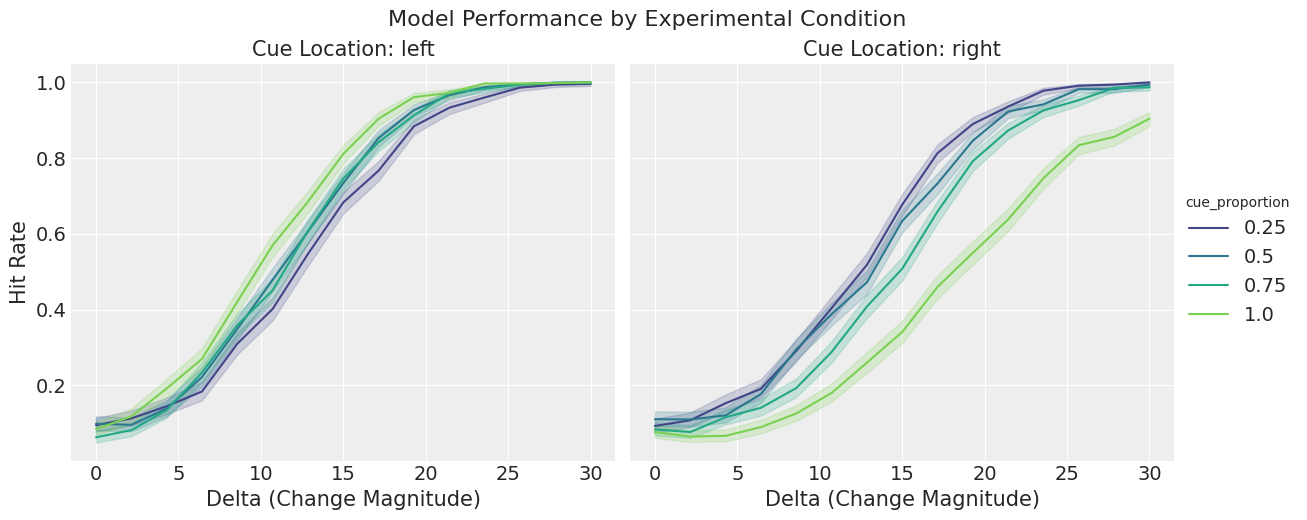

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist

# This code assumes your data is already loaded in a DataFrame named 'df'.

# --- 1. Calculate Hit Rates and Confidence Intervals ---

# Create a column for hits (1 if response is 'H', 0 otherwise)
df['is_hit'] = (df['response'] == 'H').astype(int)

# Group by the experimental conditions and aggregate the results
agg_df = df.groupby(['cue_location', 'cue_proportion', 'delta']).agg(
    H=('is_hit', 'sum'),
    trials=('is_hit', 'count')
).reset_index()

# Calculate the hit rate
agg_df['hit_rate'] = agg_df['H'] / agg_df['trials']

# Calculate the 95% Jeffreys confidence interval for the hit rate
alpha = agg_df['H'] + 0.5
beta = agg_df['trials'] - agg_df['H'] + 0.5
agg_df['ci_lower'] = beta_dist.ppf(0.025, alpha, beta)
agg_df['ci_upper'] = beta_dist.ppf(0.975, alpha, beta)

# Display the first few rows of the new aggregated table
print("--- Aggregated Performance Data ---")
print(agg_df.head())


# --- 2. Visualize the Results ---

print("\nGenerating performance plot...")

# Create a color palette so we can match the fill colors to the line colors
unique_proportions = sorted(agg_df['cue_proportion'].unique())
palette = sns.color_palette("viridis", n_colors=len(unique_proportions))
palette_dict = dict(zip(unique_proportions, palette))

# Create a comprehensive plot using seaborn's relplot
g = sns.relplot(
    data=agg_df,
    x='delta',
    y='hit_rate',
    hue='cue_proportion',
    col='cue_location',
    kind='line',
    palette=palette_dict,
    height=5,
    aspect=1.2,
    legend='full'
)

# Add the shaded confidence interval bands
for ax, col_val in zip(g.axes.flat, g.col_names):
    for cue_prop in unique_proportions:
        subset = agg_df[(agg_df['cue_location'] == col_val) & (agg_df['cue_proportion'] == cue_prop)]
        if not subset.empty:
            ax.fill_between(
                subset['delta'],
                subset['ci_lower'],
                subset['ci_upper'],
                color=palette_dict[cue_prop],
                alpha=0.2
            )

# Set titles and labels for clarity
g.fig.suptitle('Model Performance by Experimental Condition', y=1.03, fontsize=16)
g.set_axis_labels('Delta (Change Magnitude)', 'Hit Rate')
g.set_titles("Cue Location: {col_name}")

plt.show()

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Load and Combine Data ---

# Create a list of filenames for your 10 models
# Adjust the range if your models are numbered differently (e.g., 1 to 10)
file_paths = [f'/content/model_{i}_evaluation_results.csv' for i in range(10)]

# Load each CSV and store them in a list
all_dfs = []
for path in file_paths:
    try:
        df = pd.read_csv(path)
        all_dfs.append(df)
    except FileNotFoundError:
        print(f"Warning: Could not find file {path}. It will be skipped.")

# Concatenate all individual DataFrames into one master DataFrame
master_df = pd.concat(all_dfs, ignore_index=True)

print(f"Successfully loaded and combined data from {len(all_dfs)} models.")


# --- 2. Aggregate the Combined Data ---

# Create a column for hits (1 if response is 'H', 0 otherwise)
master_df['is_hit'] = (master_df['response'] == 'H').astype(int)

# Group by model number and the experimental conditions
agg_df_all_models = master_df.groupby(['model_num', 'cue_location', 'cue_proportion', 'delta']).agg(
    H=('is_hit', 'sum'),
    trials=('is_hit', 'count')
).reset_index()

# Calculate the hit rate
agg_df_all_models['hit_rate'] = agg_df_all_models['H'] / agg_df_all_models['trials']

print("\n--- Aggregated Performance Data for All Models (First 5 Rows) ---")
print(agg_df_all_models.head())

Successfully loaded and combined data from 10 models.

--- Aggregated Performance Data for All Models (First 5 Rows) ---
   model_num cue_location  cue_proportion     delta    H  trials  hit_rate
0          0         left            0.25  0.000000   95    1000     0.095
1          0         left            0.25  2.142857  113    1000     0.113
2          0         left            0.25  4.285714  145    1000     0.145
3          0         left            0.25  6.428571  184    1000     0.184
4          0         left            0.25  8.571429  310    1000     0.310


/tmp/ipython-input-4028450952.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


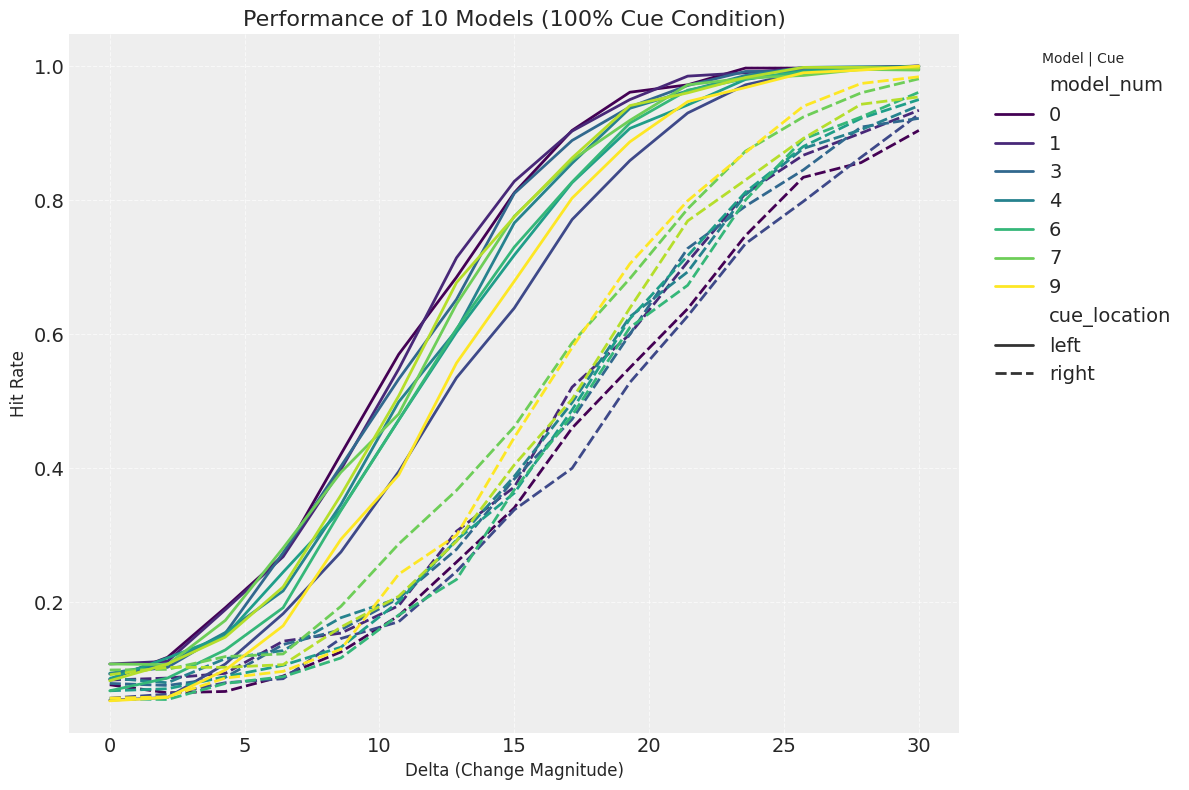

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Filter for the 100% Cue Condition ---
df_cue_100 = agg_df_all_models[agg_df_all_models['cue_proportion'] == 1.0]


# --- Create the Plot ---
plt.figure(figsize=(12, 8))

# Use seaborn to plot all models at once
sns.lineplot(
    data=df_cue_100,
    x='delta',
    y='hit_rate',
    hue='model_num',         # Different color for each model
    style='cue_location',    # Different line style for left/right
    palette='viridis',       # A color-friendly palette
    linewidth=2
)

plt.title('Performance of 10 Models (100% Cue Condition)', fontsize=16)
plt.xlabel('Delta (Change Magnitude)', fontsize=12)
plt.ylabel('Hit Rate', fontsize=12)
plt.legend(title='Model | Cue', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Filtering for condition: Cue Right, Delta = 21.43


/tmp/ipython-input-77925694.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


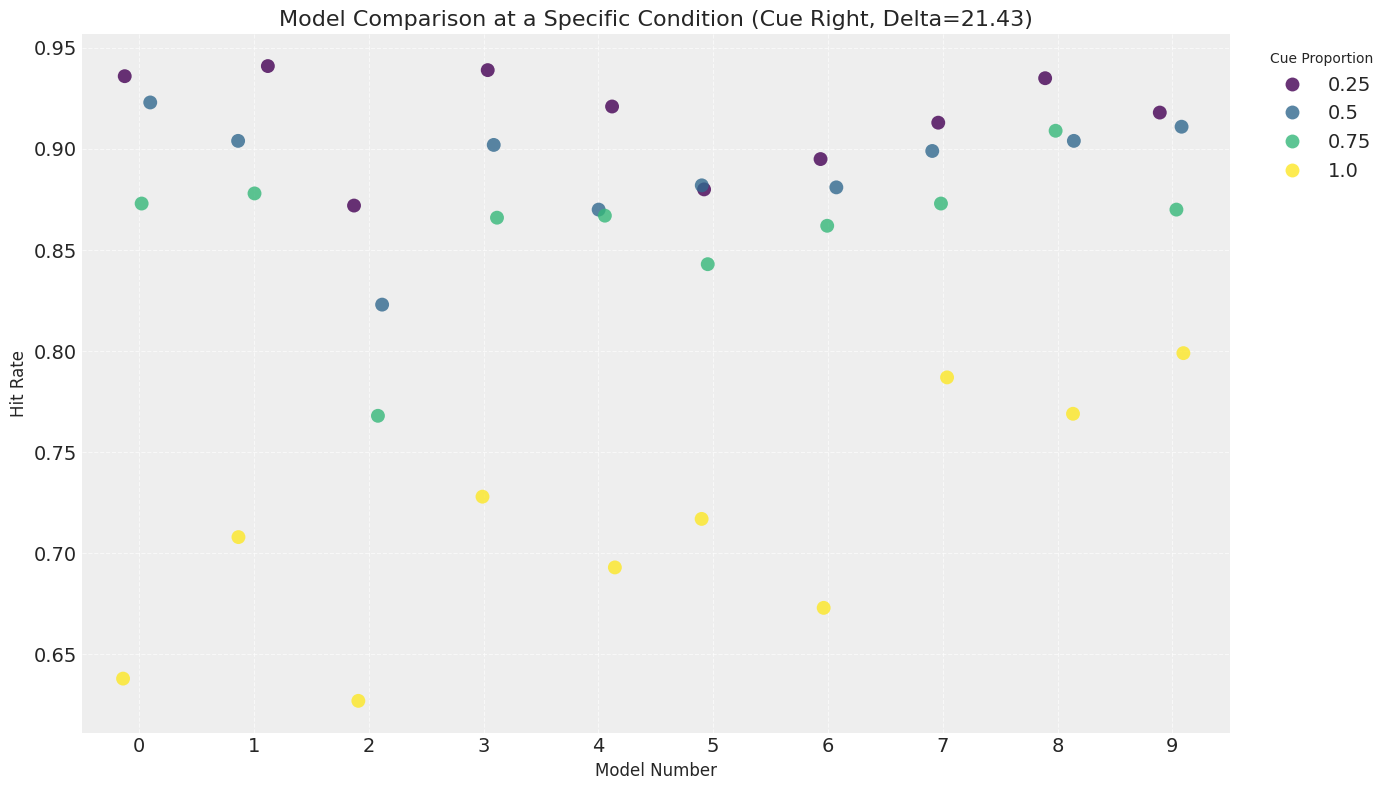

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# This code assumes you have the 'agg_df_all_models' DataFrame from the previous step.

# --- 1. Isolate the Specific Condition ---

# Find the 11th unique delta value (index 10)
try:
    unique_deltas = sorted(agg_df_all_models['delta'].unique())
    target_delta = unique_deltas[10]
except IndexError:
    print(f"Error: Could not find delta at index 10. Only {len(unique_deltas)} unique deltas exist.")
    target_delta = unique_deltas[-1] # Fallback to the last available delta

print(f"Filtering for condition: Cue Right, Delta = {target_delta:.2f}")

# Filter the DataFrame for the specific conditions
df_specific = agg_df_all_models[
    (agg_df_all_models['cue_location'] == 'right') &
    (agg_df_all_models['delta'] == target_delta)
]


# --- 2. Plot the Results ---
plt.figure(figsize=(14, 8))

sns.stripplot(
    data=df_specific,
    x='model_num',
    y='hit_rate',
    hue='cue_proportion',
    palette='viridis',
    jitter=0.15,
    size=10,
    alpha=0.8
)

plt.title(f'Model Comparison at a Specific Condition (Cue Right, Delta={target_delta:.2f})', fontsize=16)
plt.xlabel('Model Number', fontsize=12)
plt.ylabel('Hit Rate', fontsize=12)
plt.legend(title='Cue Proportion', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3802039841.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipython-input-3802039841.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


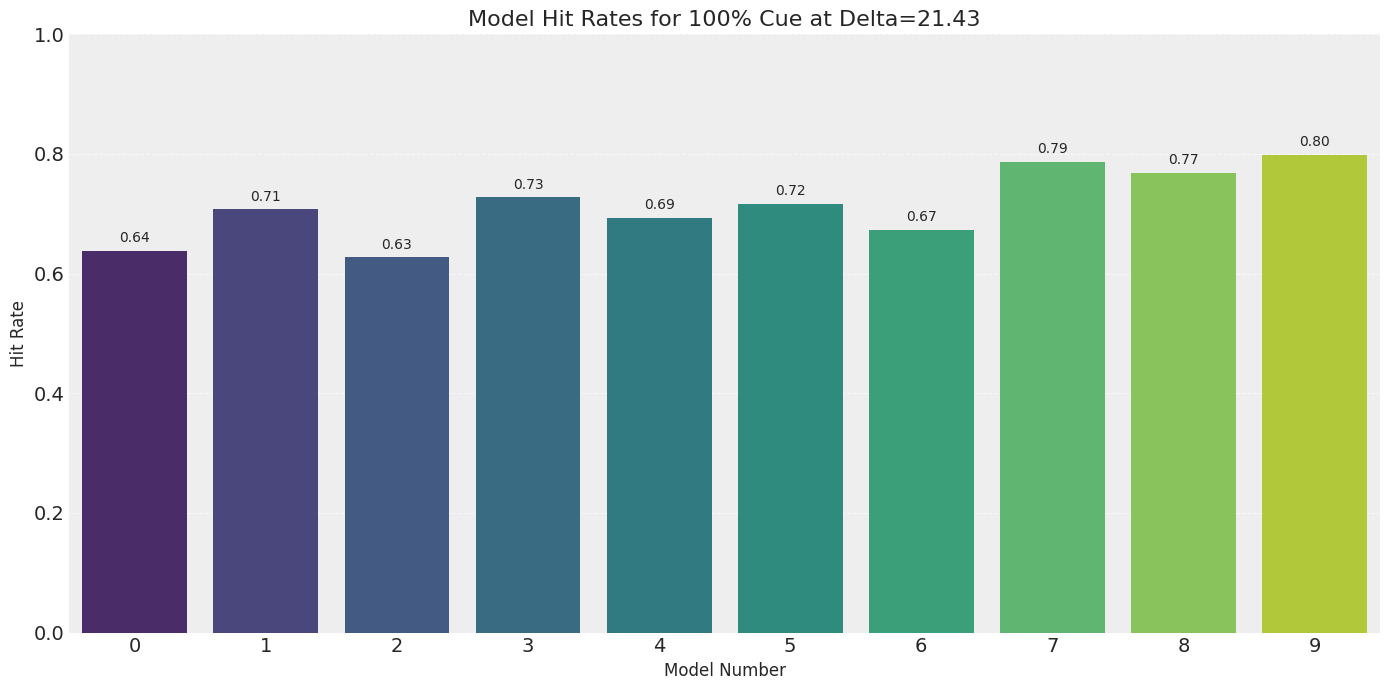

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# This code assumes you have the 'df_specific' DataFrame from the previous step.

# --- 1. Filter for the 100% Cue Condition ---
df_cue_100_specific = df_specific[df_specific['cue_proportion'] == 1.0]

# --- 2. Plot the Results ---
plt.figure(figsize=(14, 7))

barplot = sns.barplot(
    data=df_cue_100_specific,
    x='model_num',
    y='hit_rate',
    palette='viridis',
    width=0.8
)

# Add the hit rate values on top of each bar for clarity
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

# Use the target_delta variable from the previous cell for the title
plt.title(f'Model Hit Rates for 100% Cue at Delta={target_delta:.2f}', fontsize=16)
plt.xlabel('Model Number', fontsize=12)
plt.ylabel('Hit Rate', fontsize=12)
plt.ylim(0, 1) # Set y-axis from 0 to 1 for hit rates
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

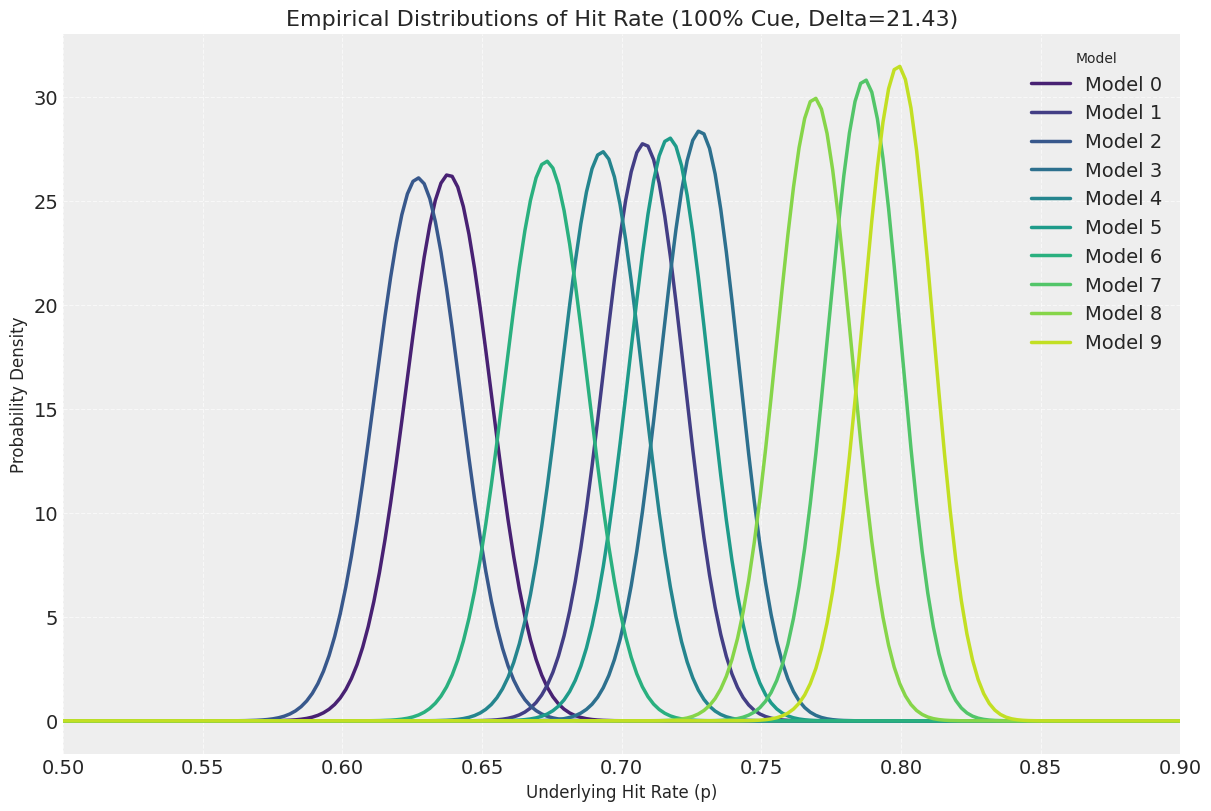

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta as beta_dist

# This code assumes you have the 'df_cue_100_specific' and 'target_delta' variables.

plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", n_colors=len(df_cue_100_specific))
x = np.linspace(0, 1, 500)

for i, (original_index, row) in enumerate(df_cue_100_specific.iterrows()):
    model_num = int(row['model_num'])
    hits = row['H']
    trials = row['trials']

    alpha = hits + 1
    beta = trials - hits + 1

    pdf = beta_dist.pdf(x, a=alpha, b=beta)

    plt.plot(x, pdf, label=f'Model {model_num}', color=palette[i], linewidth=2.5)

# --- THE FIX IS HERE ---
# Zoom in on the x-axis where the distributions are located
plt.xlim(0.5, 0.9)

plt.title(f'Empirical Distributions of Hit Rate (100% Cue, Delta={target_delta:.2f})', fontsize=16)
plt.xlabel('Underlying Hit Rate (p)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(title='Model')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

--- Isolating data for Cue Right, 100% Proportion, Delta = 21.43 ---
Data for this condition:
      model_num cue_location  cue_proportion      delta    H  trials  hit_rate
115           0        right             1.0  21.428571  638    1000     0.638
235           1        right             1.0  21.428571  708    1000     0.708
355           2        right             1.0  21.428571  627    1000     0.627
475           3        right             1.0  21.428571  728    1000     0.728
595           4        right             1.0  21.428571  693    1000     0.693
715           5        right             1.0  21.428571  717    1000     0.717
835           6        right             1.0  21.428571  673    1000     0.673
955           7        right             1.0  21.428571  787    1000     0.787
1075          8        right             1.0  21.428571  769    1000     0.769
1195          9        right             1.0  21.428571  799    1000     0.799

--- Running model for K = 2 clusters

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

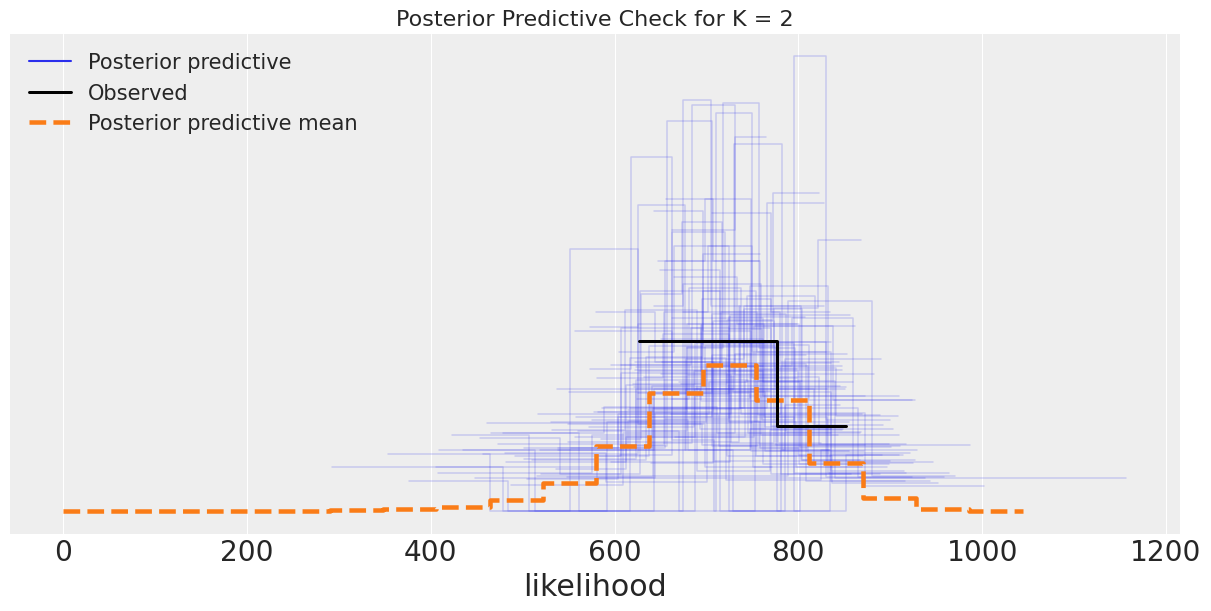


--- Running model for K = 3 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

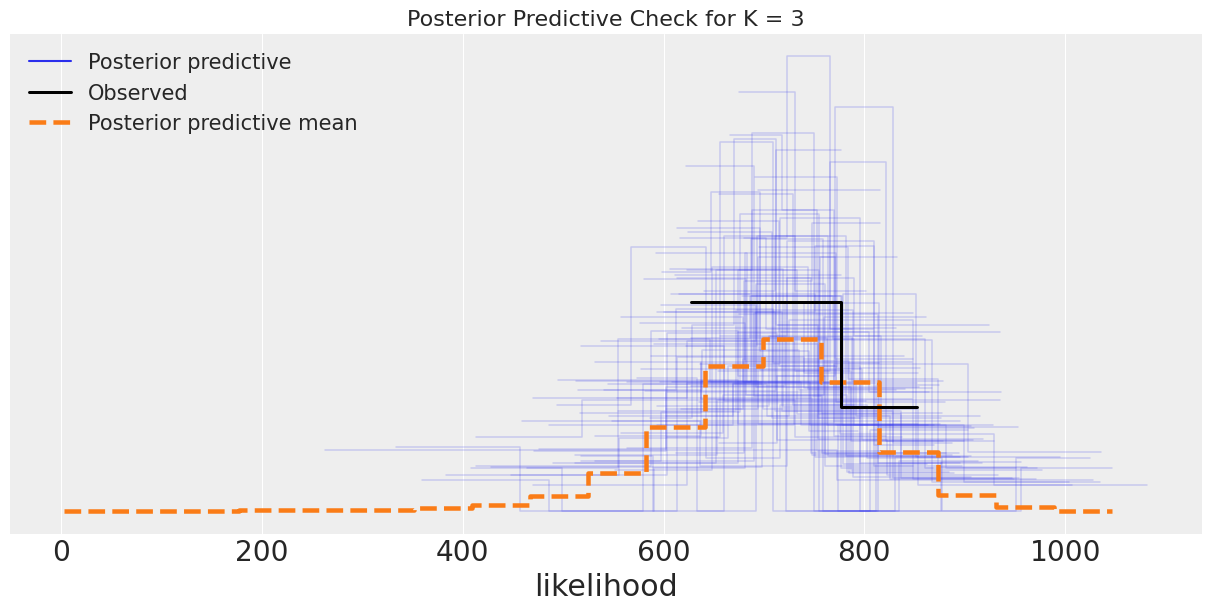


--- Running model for K = 4 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

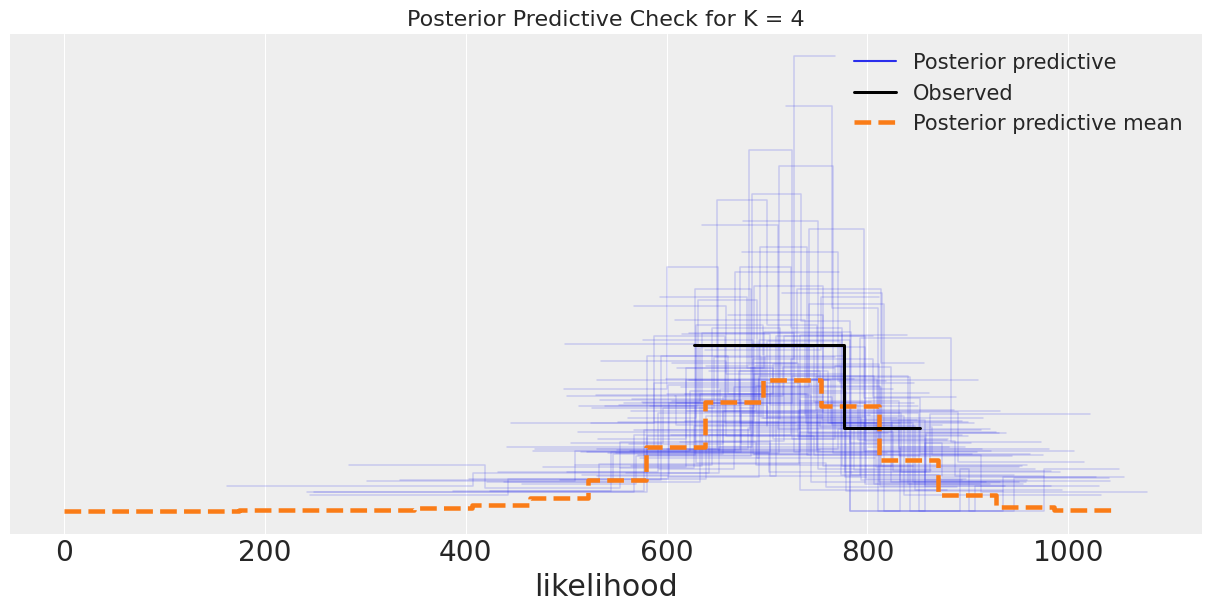


--- Running model for K = 5 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

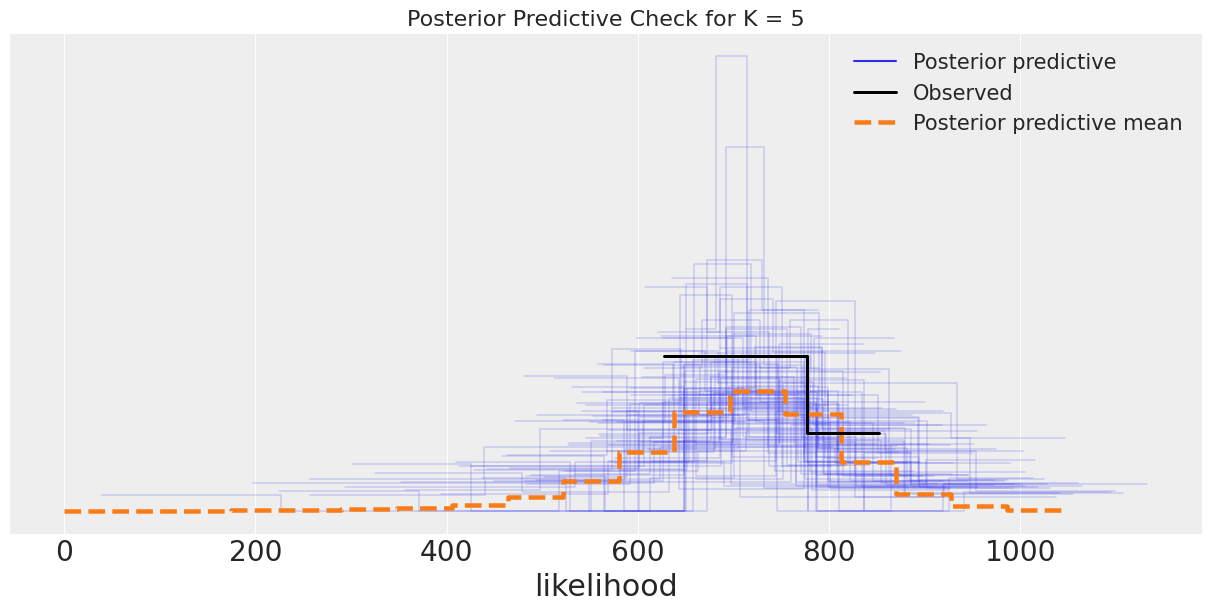


--- Running model for K = 6 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

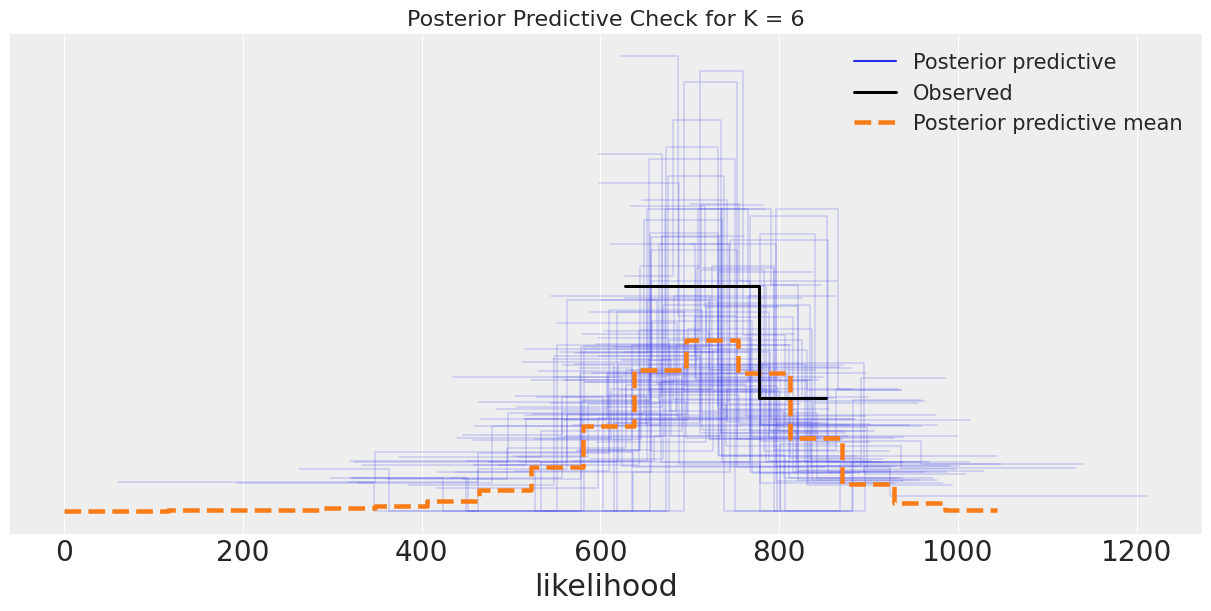


--- Running model for K = 7 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

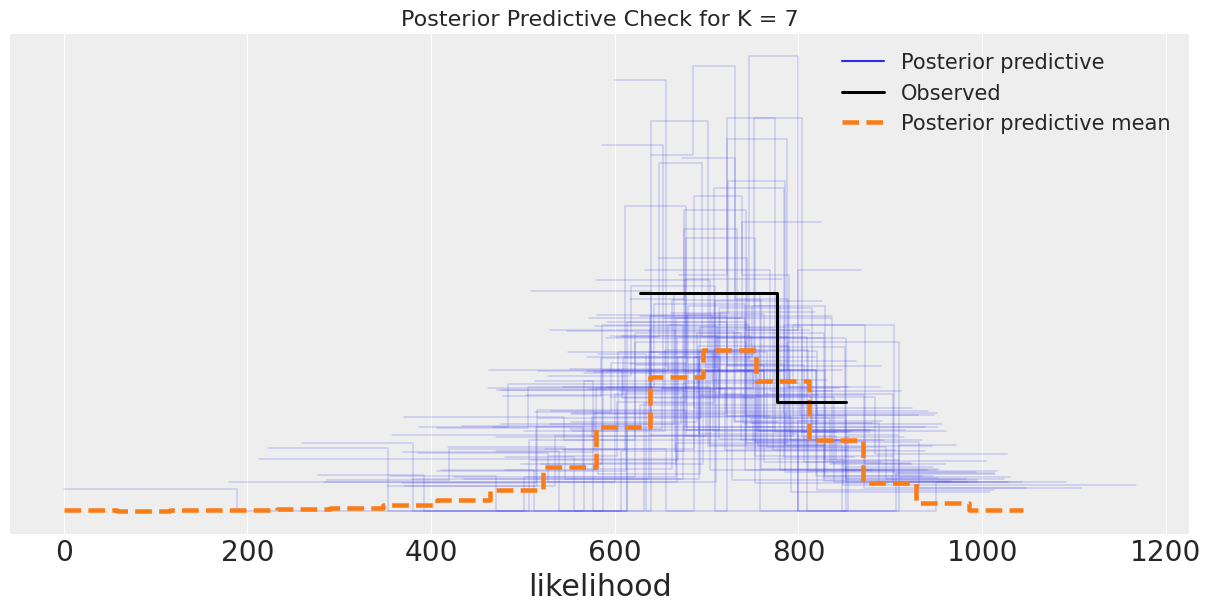


--- Running model for K = 8 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

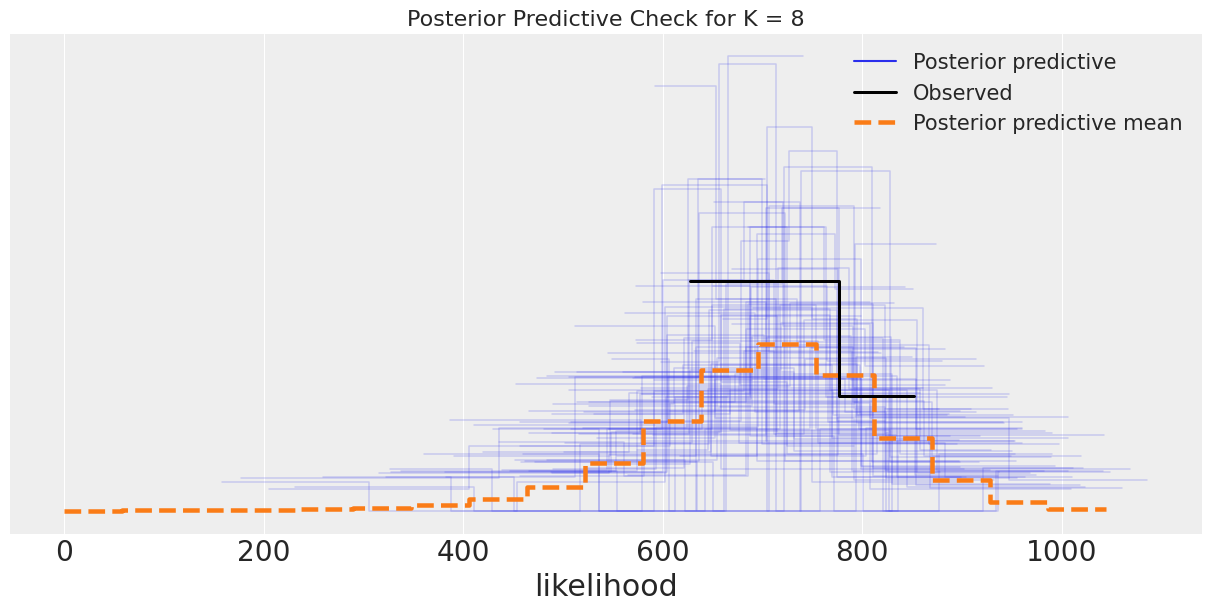


--- Running model for K = 9 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

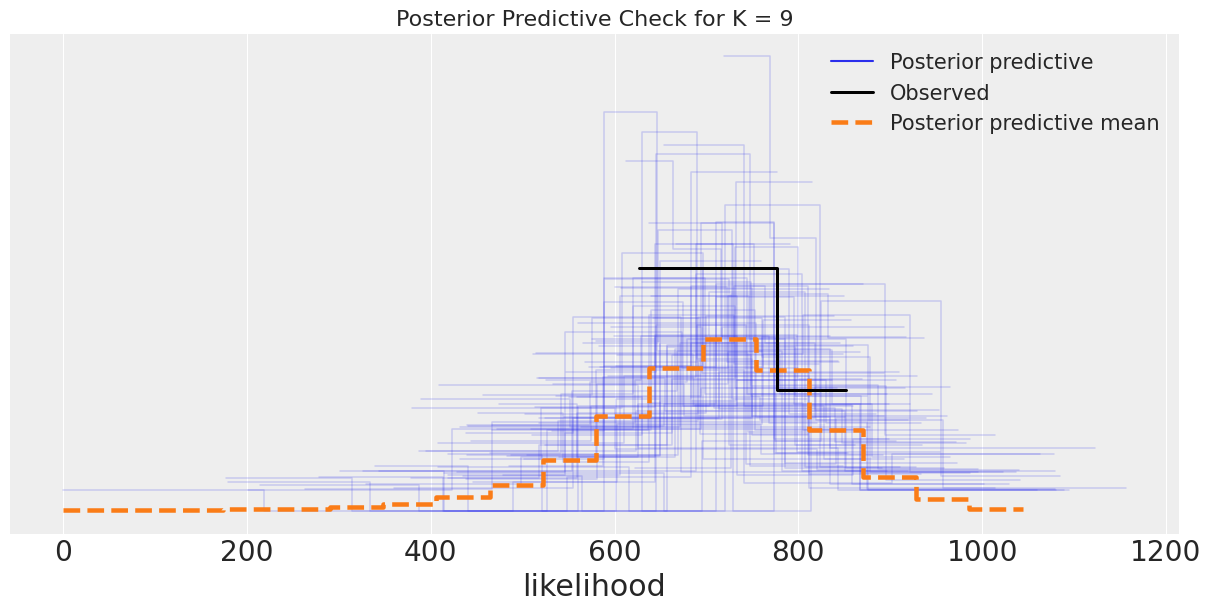


--- Running model for K = 10 clusters ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

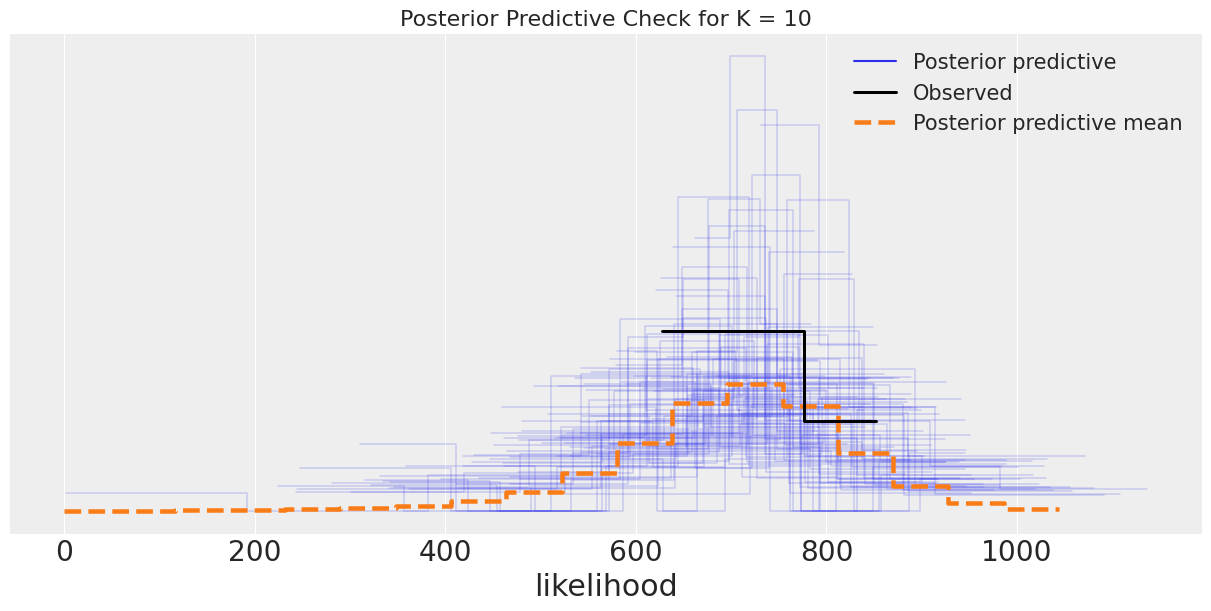

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This code assumes you have 'agg_df_all_models' and 'target_delta' from previous steps.

# --- 1. Filter Data for the Specific Condition ---
print(f"--- Isolating data for Cue Right, 100% Proportion, Delta = {target_delta:.2f} ---")
specific_condition_df = agg_df_all_models[
    (agg_df_all_models['cue_location'] == 'right') &
    (agg_df_all_models['cue_proportion'] == 1.0) &
    (agg_df_all_models['delta'] == target_delta)
].copy()

S_obs_specific = specific_condition_df['H'].values
N_trials_specific = specific_condition_df['trials'].values
N_MODELS_SPECIFIC = len(specific_condition_df)

print("Data for this condition:")
print(specific_condition_df)

# --- 2. Loop Through Models and Generate PPC Plots ---
idata_dict_specific = {} # To store results

for k_clusters in range(2, 11):
    print(f"\n--- Running model for K = {k_clusters} clusters ---")
    with pm.Model() as model:
        # Using your original, trusted model structure
        pi = pm.Dirichlet('pi', a=np.ones(k_clusters))
        kappa_k = pm.Gamma('kappa_k', alpha=2.0, beta=0.1, shape=k_clusters)
        mu_k = pm.Beta(
            'mu_k', alpha=1.0, beta=1.0, shape=k_clusters,
            transform=pm.distributions.transforms.ordered,
            initval=np.linspace(0.6, 0.8, k_clusters) # initval adjusted for this data's range
        )
        alpha_k = pm.Deterministic('alpha_k', mu_k * kappa_k)
        beta_k = pm.Deterministic('beta_k', (1 - mu_k) * kappa_k)
        assignments = pm.Categorical('assignments', p=pi, shape=N_MODELS_SPECIFIC)
        likelihood = pm.BetaBinomial(
            'likelihood',
            n=N_trials_specific,
            alpha=alpha_k[assignments],
            beta=beta_k[assignments],
            observed=S_obs_specific
        )
        # Sample WITHOUT the log_likelihood argument that causes crashes
        idata = pm.sample(draws=2000, tune=2000, chains=4, random_seed=RANDOM_SEED, target_accept=0.95)

        # Generate and add posterior predictive samples
        ppc = pm.sample_posterior_predictive(idata)
        idata.add_groups({"posterior_predictive": ppc.posterior_predictive})

        # Store the results
        idata_dict_specific[k_clusters] = idata

    # Plot the results for this k
    az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 6))
    plt.title(f'Posterior Predictive Check for K = {k_clusters}', fontsize=16)
    plt.show()

## **Mathematical Appendix: The Bayesian Mixture Model**

This section details the statistical foundation of the hierarchical model used to identify clusters of behavior among the trained neural networks.

---
### The Generative Story

The most intuitive way to understand a hierarchical model is to think of it as a "generative story"—a step-by-step process of how our observed data could have come into being.

1.  **Nature Chooses Cluster Proportions ($\pi$):** First, we assume there are $K$ distinct "types" or clusters of models in the universe (e.g., 'bad', 'mediocre', 'excellent'). Nature decides the overall proportion of each type, $\pi = \{\pi_1, \dots, \pi_K\}$, by drawing from a **Dirichlet distribution**. For example, it might decide that 30% of models are 'bad', 50% are 'mediocre', and 20% are 'excellent'.

2.  **Nature Defines Each Cluster's Performance Profile ($\mu_k, \kappa_k$):** For each of the $K$ clusters, nature defines its performance profile. We model this profile with a **Beta distribution**, which is perfect for representing the distribution of hit rates. We define this Beta distribution by its mean hit rate, $\mu_k$, and its concentration (or certainty), $\kappa_k$. A high $\kappa_k$ means all models in that cluster perform very similarly to the mean $\mu_k$. A low $\kappa_k$ means there's more performance variation within the cluster.

3.  **Each Model is Assigned to a Cluster ($z_i$):** For each of our $N$ real models, we assign it to one of the $K$ clusters. This assignment, $z_i$, is a latent (hidden) variable drawn from a **Categorical distribution** using the proportions $\pi$ from step 1.

4.  **Each Model's True Hit Rate is Realized ($\theta_i$):** Once a model $i$ is assigned to cluster $z_i$, its own true (but still unobserved) hit rate, $\theta_i$, is drawn from that cluster's specific Beta distribution, i.e., $\text{Beta}(\alpha_{z_i}, \beta_{z_i})$.

5.  **We Observe the Successes ($S_i$):** Finally, we conduct an experiment. For each model $i$, we run $n_i$ trials. The number of successes, $S_i$, that we actually observe is drawn from a **Binomial distribution**, conditioned on that model's true hit rate $\theta_i$.

This story creates a clear hierarchy, where high-level parameters ($\pi, \mu_k, \kappa_k$) inform lower-level ones ($z_i, \theta_i$), which ultimately generate our data ($S_i$).

---
### The Mathematical Formulation

Here are the specific distributions that formalize the story above.

#### 1. The Likelihood: Beta-Binomial Distribution
Our observed data for a single model $i$ consists of $S_i$ successes in $n_i$ trials. If we knew its true hit rate $\theta_i$, the likelihood would simply be Binomial:
$$ S_i | n_i, \theta_i \sim \text{Binomial}(n_i, \theta_i) $$
However, $\theta_i$ is unknown. We only know that it comes from a Beta distribution defined by its cluster's parameters, $(\alpha_k, \beta_k)$, where $k$ is the cluster model $i$ belongs to.
$$ \theta_i | \alpha_k, \beta_k \sim \text{Beta}(\alpha_k, \beta_k) $$
In the Bayesian model, we can integrate out (or "average over") the unknown $\theta_i$. This process of combining a Binomial likelihood with a Beta prior results in the **Beta-Binomial distribution**. This is our marginal likelihood for the observed successes, given only the cluster's high-level parameters:
$$ S_i | n_i, \alpha_k, \beta_k \sim \text{BetaBinomial}(n_i, \alpha_k, \beta_k) $$

#### 2. The Mixture Components
To assign models to clusters, we use two components:

* **Latent Cluster Assignments ($z_i$):** For each model $i$, a hidden variable $z_i \in \{1, \dots, K\}$ indicates its cluster membership. It follows a **Categorical distribution** parameterized by the cluster weights, $\pi$.
    $$ z_i | \pi \sim \text{Categorical}(\pi) $$
* **Cluster Weights ($\pi$):** The vector of weights $\pi = \{\pi_1, \dots, \pi_K\}$ represents the probability of belonging to each cluster. Since these probabilities must sum to 1, the standard prior is a **Dirichlet distribution**.
    $$ \pi \sim \text{Dirichlet}(\delta_1, \dots, \delta_K) $$
    We use a symmetric, uninformative prior by setting all $\delta_k = 1$.

#### 3. The Hyperpriors: Defining the Clusters
Each cluster $k$ is defined by its own Beta distribution with parameters $\alpha_k$ and $\beta_k$. The priors on these parameters are called **hyperpriors**. For better sampling stability and more intuitive interpretation, we reparameterize $(\alpha_k, \beta_k)$ into a mean $(\mu_k)$ and concentration $(\kappa_k)$:
* Mean hit rate: $\mu_k = \frac{\alpha_k}{\alpha_k + \beta_k}$
* Concentration: $\kappa_k = \alpha_k + \beta_k$

We then place priors on these new, more intuitive hyperparameters:
* $\mu_k \sim \text{Beta}(a, b)$: The prior for the cluster's mean hit rate.
* $\kappa_k \sim \text{Gamma}(c, d)$: The prior for the cluster's concentration.

---
### Full Model Specification

Putting it all together, the complete formal specification of the model is as follows, for each model $i \in \{1, \dots, N\}$ and each cluster $k \in \{1, \dots, K\}$:

1.  **Cluster Weight Prior:**
    $$ \pi \sim \text{Dirichlet}(1, \dots, 1) $$
2.  **Hyperpriors:**
    $$ \mu_k \sim \text{Beta}(1, 1) \quad \text{(or Beta(2,2) for more stability)} $$
    $$ \kappa_k \sim \text{Gamma}(2.0, 0.1) $$
3.  **Parameter Transformation:**
    $$ \alpha_k = \mu_k \kappa_k $$
    $$ \beta_k = (1 - \mu_k) \kappa_k $$
4.  **Latent Assignment:**
    $$ z_i | \pi \sim \text{Categorical}(\pi) $$
5.  **Likelihood:**
    $$ S_i | n_i, z_i, \{\alpha_k, \beta_k\} \sim \text{BetaBinomial}(n_i, \alpha_{z_i}, \beta_{z_i}) $$

---
### Inference

The goal of our analysis is to compute the posterior distribution for all unknown quantities (like $\pi$, $\mu_k$, $\kappa_k$, and $z_i$) given our observed data ($S_i$ and $n_i$). This posterior is given by Bayes' Theorem:
$$ P(\text{parameters} | \text{data}) \propto P(\text{data} | \text{parameters}) \times P(\text{parameters}) $$
Because our model is complex, we cannot solve this equation analytically. Instead, we use computational methods like **Markov Chain Monte Carlo (MCMC)**. The specific algorithm used by PyMC, the No-U-Turn Sampler (NUTS), is a highly efficient MCMC method that explores the parameter space and draws thousands of samples. The collection of these samples forms an empirical approximation of the true posterior distribution, which we then use for our analysis and plotting.

### Derivation of the Joint Posterior Distribution

The posterior distribution is defined by Bayes' Theorem, which states that the posterior is proportional to the likelihood of the data times the prior probability of the parameters.

$$
P(\text{parameters} | \text{data}) \propto P(\text{data} | \text{parameters}) \times P(\text{parameters})
$$

Let's define our terms:
* **Parameters ($\Omega$):** The set of all unknown quantities is $\Omega = \{\pi, \{\mu_k, \kappa_k\}_{k=1}^K, \{z_i\}_{i=1}^N\}$.
* **Data ($D$):** The observed data is $D = \{\{S_i, n_i\}\}_{i=1}^N\}$.

Our goal is to derive the expression for $P(\Omega | D)$.

---
#### 1. The Likelihood Term: $P(D | \Omega)$

The likelihood is the probability of observing our specific data ($S_1, \dots, S_N$) given a complete set of parameters. Since each model's observation is independent, the total likelihood is the product of the individual likelihoods. The likelihood for a single observation $S_i$ is given by the Beta-Binomial distribution, where the parameters $(\alpha_{z_i}, \beta_{z_i})$ are determined by the cluster $z_i$ that model $i$ is assigned to.

$$
P(D | \Omega) = \prod_{i=1}^{N} P(S_i | n_i, z_i, \{\alpha_k, \beta_k\}) = \prod_{i=1}^{N} \text{BetaBinomial}(S_i | n_i, \alpha_{z_i}, \beta_{z_i})
$$

where $\alpha_{z_i} = \mu_{z_i} \kappa_{z_i}$ and $\beta_{z_i} = (1 - \mu_{z_i}) \kappa_{z_i}$.

---
#### 2. The Prior Term: $P(\Omega)$

The joint prior is the probability of the parameters before observing any data. Since we defined our priors to be independent of each other, we can write the joint prior as the product of the individual priors for all parameters in $\Omega$.

$$
P(\Omega) = P(\pi) \times \left( \prod_{k=1}^{K} P(\mu_k) P(\kappa_k) \right) \times \left( \prod_{i=1}^{N} P(z_i | \pi) \right)
$$

Substituting the specific distributions we chose in our model:

$$
P(\Omega) = \underbrace{\text{Dirichlet}(\pi | \mathbf{1})}_{\text{Prior on cluster weights}} \times \prod_{k=1}^{K} \underbrace{\text{Beta}(\mu_k | 2, 2)}_{\text{Prior on cluster means}} \cdot \underbrace{\text{Gamma}(\kappa_k | 2.0, 0.1)}_{\text{Prior on cluster concentrations}} \times \prod_{i=1}^{N} \underbrace{\text{Categorical}(z_i | \pi)}_{\text{Prior on assignments}}
$$

---
### 3. The Full Joint Posterior

Now we combine the likelihood and the prior to get the unnormalized joint posterior distribution:

$$
P(\Omega | D) \propto \left[ \prod_{i=1}^{N} \text{BetaBinomial}(S_i | n_i, \alpha_{z_i}, \beta_{z_i}) \right] \times \text{Dirichlet}(\pi | \mathbf{1}) \times \left[ \prod_{k=1}^{K} \text{Beta}(\mu_k | 2, 2) \cdot \text{Gamma}(\kappa_k | 2.0, 0.1) \right] \times \left[ \prod_{i=1}^{N} \text{Categorical}(z_i | \pi) \right]
$$

---
### 4. The Log-Posterior

For numerical stability and mathematical convenience (turning products into sums), the MCMC sampler works with the **logarithm of the posterior**. This is the function that the NUTS algorithm actually evaluates:

$$
\log P(\Omega | D) = C + \sum_{i=1}^{N} \log P(S_i | \cdot) + \log P(\pi) + \sum_{k=1}^{K} \left[ \log P(\mu_k) + \log P(\kappa_k) \right] + \sum_{i=1}^{N} \log P(z_i | \pi)
$$

Where $C$ is a constant that doesn't depend on the parameters. The algorithm uses the gradient of this complex, high-dimensional function to navigate the parameter space and draw samples, ultimately building up a picture of the posterior distributions for all of our unknown parameters.